Le dataset data_rating_corporate contient des observations événementielles de notations de crédit attribuées à des entreprises par des agences de rating. Après mise en forme en panel temporel, ces données permettent de reconstruire les migrations de rating par secteur, qui constituent l’information clé utilisée pour extraire les facteurs de risque systémiques sectoriels dans le cadre du modèle CreditMetrics.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Charger le fichier Excel
df = pd.read_excel("data\credit_ratings\data_rating_corporate.xlsx")

# Afficher les premières lignes
df.head()

,rating_agency_name,rating,rating_action_date,legal_entity_identifier,obligor_name,year_month,year,pays,nace
0,Egan-Jones Ratings Company,B,2022-07-22,NaN,"06 ENVIRONMENTAL, LLC",2022-07-01,2023,NaN,RU
1,Egan-Jones Ratings Company,B,2023-07-21,NaN,"06 ENVIRONMENTAL, LLC",2023-07-01,2024,NaN,RU
2,Egan-Jones Ratings Company,B,2023-09-18,NaN,"06 ENVIRONMENTAL, LLC",2023-09-01,2024,NaN,RU
3,Fitch Ratings,B,2021-08-18,549300ETSKJL315VDV79,"11065220 Canada, Inc.",2021-08-01,2022,NaN,RU
4,Fitch Ratings,C,2022-06-27,549300ETSKJL315VDV79,"11065220 Canada, Inc.",2022-06-01,2022,NaN,RU


In [4]:
df.info()
df.describe()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109161 entries, 0 to 109160
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   rating_agency_name       109161 non-null  object
 1   rating                   109161 non-null  object
 2   rating_action_date       109161 non-null  object
 3   legal_entity_identifier  64310 non-null   object
 4   obligor_name             109161 non-null  object
 5   year_month               109161 non-null  object
 6   year                     109161 non-null  int64 
 7   pays                     66414 non-null   object
 8   nace                     109161 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.5+ MB


rating_agency_name         object
rating                     object
rating_action_date         object
legal_entity_identifier    object
obligor_name               object
year_month                 object
year                        int64
pays                       object
nace                       object
dtype: object

## On néttoie les données

In [5]:
def clean_data_rating_corporate(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Dates
    df["rating_action_date"] = pd.to_datetime(df["rating_action_date"], errors="coerce")

    # year_month : souvent "YYYY-MM-01" en string -> datetime Month Start
    df["year_month"] = pd.to_datetime(df["year_month"], errors="coerce")

    # Si year_month est manquant mais rating_action_date est dispo, on le reconstruit
    missing_ym = df["year_month"].isna() & df["rating_action_date"].notna()
    df.loc[missing_ym, "year_month"] = df.loc[missing_ym, "rating_action_date"].dt.to_period("M").dt.to_timestamp()

    # 2) Strings : trim
    for c in ["rating_agency_name", "rating", "legal_entity_identifier", "obligor_name", "pays", "nace"]:
        df[c] = df[c].astype("string").str.strip()

    # 3) ID entreprise : LEI si dispo sinon nom
    lei_ok = df["legal_entity_identifier"].notna() & (df["legal_entity_identifier"] != "")
    name_ok = df["obligor_name"].notna() & (df["obligor_name"] != "")
    df["obligor_id"] = np.where(lei_ok, df["legal_entity_identifier"], np.where(name_ok, df["obligor_name"], pd.NA))

    # 4) Nettoyage secteur (NACE)
    # (Tu peux adapter selon ton codage : lettres, divisions, etc.)
    df["nace"] = df["nace"].str.upper()

    # 5) Nettoyage rating
    df["rating"] = df["rating"].str.upper()

    # 6) Filtrer les lignes inutilisables
    df = df[df["obligor_id"].notna()].copy()
    df = df[df["year_month"].notna()].copy()
    df = df[df["nace"].notna() & (df["nace"] != "")].copy()
    df = df[df["rating"].notna() & (df["rating"] != "")].copy()

    return df


def quick_diagnostics(df: pd.DataFrame):
    print("---- DIAGNOSTICS ----")
    print("Nb lignes:", len(df))
    print("Nb entreprises (obligor_id):", df["obligor_id"].nunique())
    print("Nb agences:", df["rating_agency_name"].nunique())
    print("Nb secteurs (nace):", df["nace"].nunique())
    print("Période year_month:", df["year_month"].min(), "->", df["year_month"].max())

    print("\nTop agences:")
    print(df["rating_agency_name"].value_counts().head(10))

    print("\nTop ratings:")
    print(df["rating"].value_counts().head(15))

    print("\nTop secteurs (nace):")
    print(df["nace"].value_counts().head(15))

In [6]:
df_clean = clean_data_rating_corporate(df)
quick_diagnostics(df_clean)

---- DIAGNOSTICS ----
Nb lignes: 109161
Nb entreprises (obligor_id): 13944
Nb agences: 5
Nb secteurs (nace): 18
Période year_month: 2010-07-01 00:00:00 -> 2024-04-01 00:00:00

Top agences:
rating_agency_name
Egan-Jones Ratings Company            55414
Standard & Poor's Ratings Services    38151
Moody's Investors Service              6306
Japan Credit Rating Agency,Ltd.        5856
Fitch Ratings                          3434
Name: count, dtype: Int64

Top ratings:
rating
BBB    29025
B      24599
A      22268
BB     20638
C       6638
AAA     5482
D        511
Name: count, dtype: Int64

Top secteurs (nace):
nace
KZ    13782
C5    13418
C3    11983
RU    10508
JZ    10142
BZ     8418
LZ     7427
HZ     6164
GZ     5047
C1     5032
OQ     4664
CH     2398
C4     2337
C2     2322
IZ     1901
Name: count, dtype: Int64


In [7]:
df_clean

,rating_agency_name,rating,rating_action_date,legal_entity_identifier,obligor_name,year_month,year,pays,nace,obligor_id
0,Egan-Jones Ratings Company,B,2022-07-22,<NA>,"06 ENVIRONMENTAL, LLC",2022-07-01,2023,<NA>,RU,"06 ENVIRONMENTAL, LLC"
1,Egan-Jones Ratings Company,B,2023-07-21,<NA>,"06 ENVIRONMENTAL, LLC",2023-07-01,2024,<NA>,RU,"06 ENVIRONMENTAL, LLC"
2,Egan-Jones Ratings Company,B,2023-09-18,<NA>,"06 ENVIRONMENTAL, LLC",2023-09-01,2024,<NA>,RU,"06 ENVIRONMENTAL, LLC"
3,Fitch Ratings,B,2021-08-18,549300ETSKJL315VDV79,"11065220 Canada, Inc.",2021-08-01,2022,<NA>,RU,549300ETSKJL315VDV79
4,Fitch Ratings,C,2022-06-27,549300ETSKJL315VDV79,"11065220 Canada, Inc.",2022-06-01,2022,<NA>,RU,549300ETSKJL315VDV79
...,...,...,...,...,...,...,...,...,...,...
109156,Standard & Poor's Ratings Services,BB,2013-11-26,<NA>,tw telecom inc.,2013-11-01,2014,US,JZ,tw telecom inc.
109157,Standard & Poor's Ratings Services,BB,2013-12-10,<NA>,tw telecom inc.,2013-12-01,2014,US,JZ,tw telecom inc.
109158,Standard & Poor's Ratings Services,BB,2014-06-16,<NA>,tw telecom inc.,2014-06-01,2014,US,JZ,tw telecom inc.
109159,Standard & Poor's Ratings Services,BB,2014-08-18,<NA>,tw telecom inc.,2014-08-01,2015,US,JZ,tw telecom inc.


In [ ]:

import pandas as pd
import numpy as np

# 1) Mapping économique (à adapter si C1..C5 sont connus chez toi)
ECON_GROUP_MAP = {
    # Primaires / énergie
    "AZ": "Primaires & énergie",
    "BZ": "Primaires & énergie",  # si présent

    # Industrie / construction / immobilier

    "FZ": "Construction & immobilier",
    "LZ": "Construction & immobilier",

    # Transport / info
    "JZ": "Info-com",

    # Services marchands
    "GZ": "Services",
    "IZ": "Services",
    "HZ": "Services",

    # Finance
    "KZ": "Finance",

    # Non-marchands / public
    "OQ": "Public & services non-marchands",
    "RU": "Public & services non-marchands",

    # Services pro (souvent très cycliques mais “services”)
    "MN": "Services pro",

    # Cas C1..C5 (à défaut)
    "C1": "Industrie",
    "C2": "Industrie",
    "C3": "Industrie",
    "C4": "Industrie",
    "C5": "Industrie",
    "CH": "Industrie",  # tu avais G7 dans le dendrogramme
}


def add_econ_group(df_Z, sector_col="sector"):
    df = df_Z.copy()
    df["econ_group"] = df[sector_col].map(ECON_GROUP_MAP).fillna("Autres")
    return df


df_clean=add_econ_group(df_clean, sector_col="nace")

## Choix de l'agence de notation

In [9]:
agency_dist = (
    df_clean["rating_agency_name"]
    .value_counts()
    .rename_axis("Agence")
    .reset_index(name="Nombre d'observations")
)

agency_dist["Part (%)"] = 100 * agency_dist["Nombre d'observations"] / agency_dist["Nombre d'observations"].sum()
agency_dist

,Agence,Nombre d'observations,Part (%)
0,Egan-Jones Ratings Company,55414,50.763551
1,Standard & Poor's Ratings Services,38151,34.949295
2,Moody's Investors Service,6306,5.776788
3,"Japan Credit Rating Agency,Ltd.",5856,5.364553
4,Fitch Ratings,3434,3.145812


On garde que les notations edgar jones pour l'instant


## On uniformise les notations utilisées

In [10]:
def filter_and_map_ratings(df):
    df = df.copy()

    # 1) Garder Egan-Jones
    df = df[df["rating_agency_name"] == "Egan-Jones Ratings Company"].copy()
    return df

In [11]:
df_ej= filter_and_map_ratings(df_clean)
df_ej["rating"].value_counts()

rating
BBB    16308
A      13160
BB     12106
B       7724
C       3212
AAA     2860
D         44
Name: count, dtype: Int64

In [12]:
df_ej

,rating_agency_name,rating,rating_action_date,legal_entity_identifier,obligor_name,year_month,year,pays,nace,obligor_id,econ_group
0,Egan-Jones Ratings Company,B,2022-07-22,<NA>,"06 ENVIRONMENTAL, LLC",2022-07-01,2023,<NA>,RU,"06 ENVIRONMENTAL, LLC",Public & services non-marchands
1,Egan-Jones Ratings Company,B,2023-07-21,<NA>,"06 ENVIRONMENTAL, LLC",2023-07-01,2024,<NA>,RU,"06 ENVIRONMENTAL, LLC",Public & services non-marchands
2,Egan-Jones Ratings Company,B,2023-09-18,<NA>,"06 ENVIRONMENTAL, LLC",2023-09-01,2024,<NA>,RU,"06 ENVIRONMENTAL, LLC",Public & services non-marchands
7,Egan-Jones Ratings Company,BBB,2024-02-16,2549003HMILDS2TD4746,1333 WINTERGREEN REAL ESTATE CORPORATION,2024-02-01,2024,US,LZ,2549003HMILDS2TD4746,Construction & immobilier
11,Egan-Jones Ratings Company,BB,2021-08-20,<NA>,1847 HOLDINGS LLC,2021-08-01,2022,<NA>,RU,1847 HOLDINGS LLC,Public & services non-marchands
...,...,...,...,...,...,...,...,...,...,...,...
108731,Egan-Jones Ratings Company,BB,2022-01-11,<NA>,ZYNGA INC. CLASS A,2022-01-01,2022,US,JZ,ZYNGA INC. CLASS A,Info-com
108732,Egan-Jones Ratings Company,BB,2017-11-09,254900KBWY6B6MM40362,"ZYWAVE, INC.",2017-11-01,2018,US,JZ,254900KBWY6B6MM40362,Info-com
108733,Egan-Jones Ratings Company,BB,2018-10-24,254900KBWY6B6MM40362,"ZYWAVE, INC.",2018-10-01,2019,US,JZ,254900KBWY6B6MM40362,Info-com
108734,Egan-Jones Ratings Company,B,2019-10-24,254900KBWY6B6MM40362,"ZYWAVE, INC.",2019-10-01,2020,US,JZ,254900KBWY6B6MM40362,Info-com


In [13]:
def create_quarterly_rating_transitions(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transforme les données de notation en une série temporelle trimestrielle complète
    pour chaque entreprise et calcule les transitions de notation sur 12 mois.

    Le processus se déroule en plusieurs étapes :
    1.  Conserve la dernière notation connue pour chaque entreprise dans un trimestre donné.
    2.  Crée une plage de temps complète (un "squelette") de tous les trimestres
        pour chaque entreprise, de sa première à sa dernière notation.
    3.  Fusionne les notations réelles sur ce squelette et propage la dernière
        notation connue vers l'avant (forward fill) pour combler les trimestres vides.
    4.  Calcule la notation 12 mois plus tard ('next_rating') pour chaque trimestre afin
        d'analyser les transitions.

    Args:
        data (pd.DataFrame): Un DataFrame contenant au minimum les colonnes
                             'obligor_name', 'rating_action_date', et 'rating'.
                             La colonne 'rating_action_date' doit être au format datetime.

    Returns:
        pd.DataFrame: Un DataFrame final avec une ligne par entreprise par trimestre,
                      contenant la notation du trimestre ('rating') et celle
                      12 mois après ('next_rating').
    """
    # Copie pour éviter de modifier le DataFrame original
    df = data.copy()

    # --- Étape 1: Créer une vue trimestrielle avec la dernière notation de chaque trimestre ---
    df['year_quarter'] = df['rating_action_date'].dt.to_period('Q').dt.start_time
    df_sorted = df.sort_values(by=['obligor_name', 'rating_action_date'])
    final_df = df_sorted.drop_duplicates(subset=['obligor_name', 'year_quarter'], keep='last')


    return final_df

In [14]:
df_ej = create_quarterly_rating_transitions(df_ej)

In [15]:
df_ej

,rating_agency_name,rating,rating_action_date,legal_entity_identifier,obligor_name,year_month,year,pays,nace,obligor_id,econ_group,year_quarter
0,Egan-Jones Ratings Company,B,2022-07-22,<NA>,"06 ENVIRONMENTAL, LLC",2022-07-01,2023,<NA>,RU,"06 ENVIRONMENTAL, LLC",Public & services non-marchands,2022-07-01
2,Egan-Jones Ratings Company,B,2023-09-18,<NA>,"06 ENVIRONMENTAL, LLC",2023-09-01,2024,<NA>,RU,"06 ENVIRONMENTAL, LLC",Public & services non-marchands,2023-07-01
7,Egan-Jones Ratings Company,BBB,2024-02-16,2549003HMILDS2TD4746,1333 WINTERGREEN REAL ESTATE CORPORATION,2024-02-01,2024,US,LZ,2549003HMILDS2TD4746,Construction & immobilier,2024-01-01
11,Egan-Jones Ratings Company,BB,2021-08-20,<NA>,1847 HOLDINGS LLC,2021-08-01,2022,<NA>,RU,1847 HOLDINGS LLC,Public & services non-marchands,2021-07-01
12,Egan-Jones Ratings Company,BB,2022-08-25,<NA>,1847 HOLDINGS LLC,2022-08-01,2023,<NA>,RU,1847 HOLDINGS LLC,Public & services non-marchands,2022-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...
108731,Egan-Jones Ratings Company,BB,2022-01-11,<NA>,ZYNGA INC. CLASS A,2022-01-01,2022,US,JZ,ZYNGA INC. CLASS A,Info-com,2022-01-01
108732,Egan-Jones Ratings Company,BB,2017-11-09,254900KBWY6B6MM40362,"ZYWAVE, INC.",2017-11-01,2018,US,JZ,254900KBWY6B6MM40362,Info-com,2017-10-01
108733,Egan-Jones Ratings Company,BB,2018-10-24,254900KBWY6B6MM40362,"ZYWAVE, INC.",2018-10-01,2019,US,JZ,254900KBWY6B6MM40362,Info-com,2018-10-01
108734,Egan-Jones Ratings Company,B,2019-10-24,254900KBWY6B6MM40362,"ZYWAVE, INC.",2019-10-01,2020,US,JZ,254900KBWY6B6MM40362,Info-com,2019-10-01


In [16]:
import numpy as np
import pandas as pd

RATING_MAP = {
    "AAA": "AAA", "AA": "AA", "A": "A", "BBB": "BBB",
    "BB": "BB", "B": "B",
    "CCC": "C", "CC": "C", "C": "C", "C2": "C", "C3": "C", "C4": "C",
    "D": "D", "SD": "D",
    "WR": None, "NR": None, "IZ": None,
}
RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]


def build_panel_transitions_counts_quarterly_date(
    df_ej: pd.DataFrame,
    sector_col: str = "econ_group",
    quarter_col: str = "year_quarter",          # déjà datetime (quarter start)
    action_date_col: str = "rating_action_date",
    rating_col: str = "rating",
    forward_fill_limit: int | None = None,      # ex: 8 si max 2 ans (8 trimestres)
    enforce_quarter_start: bool = True          # recale au début de trimestre si besoin
):
    df = df_ej.copy()

    # 1) cast dates
    df[action_date_col] = pd.to_datetime(df[action_date_col], errors="coerce")
    df[quarter_col] = pd.to_datetime(df[quarter_col], errors="coerce")

    # 2) obligor_id
    if "obligor_id" not in df.columns:
        lei = df.get("legal_entity_identifier")
        name = df.get("obligor_name")
        lei_ok = lei.notna() & (lei.astype(str).str.strip() != "") if lei is not None else pd.Series(False, index=df.index)
        name_ok = name.notna() & (name.astype(str).str.strip() != "") if name is not None else pd.Series(False, index=df.index)
        df["obligor_id"] = np.where(lei_ok, lei, np.where(name_ok, name, pd.NA))

    # 3) nettoyage + mapping rating
    df[sector_col] = df[sector_col].astype("string").str.strip().str.upper()
    df["rating_mapped"] = df[rating_col].astype("string").str.strip().str.upper().map(RATING_MAP)

    # 4) quarter en DATE (Timestamp)
    df["quarter"] = df[quarter_col].dt.normalize()

    # option : si jamais year_quarter n'est pas pile début de trimestre, on recale
    if enforce_quarter_start:
        df["quarter"] = df["quarter"].dt.to_period("Q").dt.start_time.dt.normalize()

    # 5) filtres
    df = df[df["obligor_id"].notna()].copy()
    df = df[df["quarter"].notna()].copy()
    df = df[df[sector_col].notna() & (df[sector_col] != "")].copy()
    df = df[df["rating_mapped"].isin(RATING_ORDER)].copy()

    # 6) si plusieurs événements même trimestre : garder le dernier (par action_date)
    df = df.sort_values(["obligor_id", sector_col, "quarter", action_date_col])

    quarterly_last = (
        df.groupby(["obligor_id", sector_col, "quarter"], as_index=False)
          .last()[["obligor_id", sector_col, "quarter", "rating_mapped"]]
          .rename(columns={"rating_mapped": "rating"})
    )

    # 7) grille trimestrielle complète (date range avec freq='QS')
    global_min = quarterly_last["quarter"].min()
    global_max = quarterly_last["quarter"].max()
    all_quarters = pd.date_range(global_min, global_max, freq="QS")  # Quarter Start

    obligors = quarterly_last[["obligor_id", sector_col]].drop_duplicates()

    grid = obligors.assign(key=1).merge(
        pd.DataFrame({"quarter": all_quarters, "key": 1}),
        on="key", how="outer"
    ).drop(columns=["key"])

    panel = grid.merge(
        quarterly_last,
        on=["obligor_id", sector_col, "quarter"],
        how="left"
    ).sort_values(["obligor_id", sector_col, "quarter"])

    # forward fill ratings par obligor/secteur
    panel["rating"] = panel.groupby(["obligor_id", sector_col])["rating"].ffill(limit=forward_fill_limit)
    panel = panel[panel["rating"].notna()].copy()

    # 8) transitions t-1 -> t
    panel["rating_prev"] = panel.groupby(["obligor_id", sector_col])["rating"].shift(1)

    transitions = panel[panel["rating_prev"].notna()].copy()
    transitions["changed"] = (transitions["rating_prev"] != transitions["rating"]).astype(int)

    transitions = transitions.rename(columns={sector_col: "sector"})[
        ["obligor_id", "sector", "quarter", "rating_prev", "rating", "changed"]
    ]

    # 9) counts
    counts = (
        transitions
        .groupby(["sector", "quarter", "rating_prev", "rating"], as_index=False)
        .size()
        .rename(columns={"size": "n"})
        .sort_values(["sector", "quarter", "rating_prev", "rating"])
    )

    panel = panel.rename(columns={sector_col: "sector"})[
        ["obligor_id", "sector", "quarter", "rating"]
    ].sort_values(["sector", "obligor_id", "quarter"])

    return panel, transitions, counts


In [17]:
panel_q, transitions_q, counts_q = build_panel_transitions_counts_quarterly_date(
    df_ej,
    sector_col="econ_group",
    quarter_col="year_quarter",
    forward_fill_limit=8,        # optionnel (évite de ffill à l’infini)
    enforce_quarter_start=True   # garde quarter en date, recale si besoin
)

print(panel_q.head())
print(panel_q["quarter"].min(), panel_q["quarter"].max())
print(panel_q.dtypes)


                obligor_id                     sector    quarter rating
4648  2549000P1W5SFJWCNP90  CONSTRUCTION & IMMOBILIER 2020-04-01    BBB
4649  2549000P1W5SFJWCNP90  CONSTRUCTION & IMMOBILIER 2020-07-01    BBB
4650  2549000P1W5SFJWCNP90  CONSTRUCTION & IMMOBILIER 2020-10-01    BBB
4651  2549000P1W5SFJWCNP90  CONSTRUCTION & IMMOBILIER 2021-01-01    BBB
4652  2549000P1W5SFJWCNP90  CONSTRUCTION & IMMOBILIER 2021-04-01    BBB
2011-01-01 00:00:00 2024-01-01 00:00:00
obligor_id            object
sector        string[python]
quarter       datetime64[ns]
rating                object
dtype: object


 Ici on voit que les note utilisées part l'agence dont AAA AA A BBB BB B C D. La note AA n'est pas présente dans les données. Ce code permet construire un panel mensuel de ratings par entreprise et par secteur, puis à déduire toutes les transitions de rating d’un mois au suivant, et enfin à compter ces transitions par secteur × mois × rating départ × rating arrivée. On utilise la méthode forward fill pour les periodes sans transitions. Le forward-fill (ou carry-forward) consiste à :
reporter la dernière valeur observée vers les périodes suivantes tant qu’aucune nouvelle observation n’apparaît.

In [18]:
# % de transitions où ça bouge vraiment (sinon trop de bruit / trop de ffill)
chg_rate = transitions_q["changed"].mean()
print("Taux de changement trimestriel:", round(100 * chg_rate, 2), "%")

# couverture par secteur (nombre de lignes dans counts = nb de couples (quarter, rating_prev, rating) non nuls)
print("\nNb d'entrées (sector, quarter, rating_prev, rating) par secteur (counts):")
print(counts_q["sector"].value_counts().head(10))

# un trimestre exemple: matrice r->k pour un secteur
s0 = counts_q["sector"].iloc[0]
t0 = counts_q["quarter"].min()   # Period, ex: 2011Q1

mat = (
    counts_q[(counts_q["sector"] == s0) & (counts_q["quarter"] == t0)]
    .pivot_table(index="rating_prev", columns="rating", values="n", aggfunc="sum", fill_value=0)
)

# optionnel: ordonner les lignes/colonnes selon l'échelle coarse
RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]
mat = mat.reindex(index=RATING_ORDER, columns=RATING_ORDER, fill_value=0)

print(f"\nMatrice de comptage pour secteur={s0}, trimestre={t0}:")
print(mat)


Taux de changement trimestriel: 3.93 %

Nb d'entrées (sector, quarter, rating_prev, rating) par secteur (counts):
sector
INDUSTRIE                          680
SERVICES                           543
PUBLIC & SERVICES NON-MARCHANDS    508
PRIMAIRES & ÉNERGIE                498
INFO-COM                           497
FINANCE                            473
CONSTRUCTION & IMMOBILIER          370
SERVICES PRO                       245
Name: count, dtype: Int64

Matrice de comptage pour secteur=CONSTRUCTION & IMMOBILIER, trimestre=2011-04-01 00:00:00:
rating       AAA  AA  A  BBB  BB  B  C  D
rating_prev                              
AAA            0   0  0    0   0  0  0  0
AA             0   0  0    0   0  0  0  0
A              0   0  0    0   0  0  0  0
BBB            0   0  0    0   0  0  0  0
BB             0   0  0    1   0  0  0  0
B              0   0  0    0   0  0  0  0
C              0   0  0    0   0  0  0  0
D              0   0  0    0   0  0  0  0


Le code précédent construit un **panel mensuel de ratings par entreprise et par secteur** à partir de données événementielles, en projetant chaque rating observé sur tous les mois suivants jusqu’à la prochaine action de notation (forward-fill). À partir de ce panel, le code identifie les **transitions mensuelles de rating** (y compris les non-changements) et en calcule les **comptages par secteur, par mois et par couple rating initial → rating final**, ce qui correspond à des matrices de transition sectorielles temporelles. Les résultats montrent un **faible taux de changement mensuel** (environ 1 %), reflétant la forte inertie des ratings de crédit, tandis que la majorité des observations se situe sur la diagonale des matrices (stabilité du rating). Cette structure est économiquement cohérente et indique que les matrices capturent bien une dynamique de risque dominée par la persistance, avec des événements de transition rares mais informatifs.


In [19]:
# nombre de trimestres couverts par secteur
quarters_per_sector = (
    counts_q
    .groupby("sector")["quarter"]
    .nunique()
    .sort_values(ascending=False)
)
print("Nombre de trimestres couverts par secteur :")
print(quarters_per_sector)

# nombre total de transitions observées par secteur
trans_per_sector = (
    transitions_q
    .groupby("sector")
    .size()
    .sort_values(ascending=False)
)
print("\nNombre total de transitions observées par secteur :")
print(trans_per_sector)


Nombre de trimestres couverts par secteur :
sector
CONSTRUCTION & IMMOBILIER          52
FINANCE                            52
INDUSTRIE                          52
INFO-COM                           52
PRIMAIRES & ÉNERGIE                52
PUBLIC & SERVICES NON-MARCHANDS    52
SERVICES                           51
SERVICES PRO                       50
Name: quarter, dtype: int64

Nombre total de transitions observées par secteur :
sector
INDUSTRIE                          27220
PUBLIC & SERVICES NON-MARCHANDS    13286
FINANCE                            13052
SERVICES                            9101
INFO-COM                            8351
CONSTRUCTION & IMMOBILIER           5527
PRIMAIRES & ÉNERGIE                 4542
SERVICES PRO                        1995
dtype: int64


# MISE EN OEUVRE MODELE CREDITMETRICS

In [20]:
import pandas as pd

RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]

def make_counts_creditmetrics(
    transitions: pd.DataFrame,
    time_col: str = "quarter",
    sector_col: str = "sector",
    obligor_col: str = "obligor_id",
    rating_prev_col: str = "rating_prev",
    rating_col: str = "rating",
    rating_order=None,
    check_nonnegative_stays: bool = True
) -> pd.DataFrame:
    """
    transitions: contient au minimum
      [obligor_col, sector_col, time_col, rating_prev_col, rating_col]
    Retourne counts_creditmetrics avec toutes les cellules, y compris r->r (stays reconstruits).
    """
    if rating_order is None:
        rating_order = RATING_ORDER

    required = {obligor_col, sector_col, time_col, rating_prev_col, rating_col}
    missing = required - set(transitions.columns)
    if missing:
        raise KeyError(f"Colonnes manquantes dans transitions: {sorted(missing)}")

    df = transitions.copy()

    # total exposés par (sector, time, rating_prev) en nb d'obligors uniques
    n_initial = (
        df.groupby([sector_col, time_col, rating_prev_col], as_index=False)
          .agg(n_total=(obligor_col, "nunique"))
    )

    # migrations observées (nb de transitions)
    n_migrations = (
        df.groupby([sector_col, time_col, rating_prev_col, rating_col], as_index=False)
          .size()
          .rename(columns={"size": "n"})
    )

    # sorties hors stay
    outgoing = (
        n_migrations[n_migrations[rating_col] != n_migrations[rating_prev_col]]
        .groupby([sector_col, time_col, rating_prev_col], as_index=False)
        .agg(n_out=("n", "sum"))
    )

    tmp = n_initial.merge(outgoing, on=[sector_col, time_col, rating_prev_col], how="left")
    tmp["n_out"] = tmp["n_out"].fillna(0).astype(int)
    tmp["n_stay"] = tmp["n_total"] - tmp["n_out"]

    if check_nonnegative_stays and (tmp["n_stay"] < 0).any():
        bad = tmp[tmp["n_stay"] < 0].head(10)
        raise ValueError(
            "n_stay négatif détecté (souvent dû à doublons obligor/time ou mauvais identifiant). "
            f"Exemples:\n{bad}"
        )

    stays = tmp[[sector_col, time_col, rating_prev_col, "n_stay"]].copy()
    stays[rating_col] = stays[rating_prev_col]
    stays = stays.rename(columns={"n_stay": "n"})

    counts = pd.concat([n_migrations, stays], ignore_index=True)

    # filtrage ratings
    counts = counts[
        counts[rating_prev_col].isin(rating_order) &
        counts[rating_col].isin(rating_order)
    ].copy()

    # agrégation finale (au cas où stays + migrations se chevauchent)
    counts = (
        counts.groupby([sector_col, time_col, rating_prev_col, rating_col], as_index=False)["n"]
              .sum()
              .sort_values([sector_col, time_col, rating_prev_col, rating_col])
    )

    # check : somme_k N(r->k) > 0
    check = counts.groupby([sector_col, time_col, rating_prev_col])["n"].sum()
    if (check <= 0).any():
        raise ValueError("Check failed: certains (sector,time,rating_prev) ont une somme <= 0.")

    return counts


# RUN (quarterly)
counts_creditmetrics_q = make_counts_creditmetrics(transitions_q, time_col="quarter")
print("counts_creditmetrics_q shape:", counts_creditmetrics_q.shape)
print(counts_creditmetrics_q.head(10))


counts_creditmetrics_q shape: (3818, 5)
                      sector    quarter rating_prev rating   n
0  CONSTRUCTION & IMMOBILIER 2011-04-01          BB     BB   0
1  CONSTRUCTION & IMMOBILIER 2011-04-01          BB    BBB   1
2  CONSTRUCTION & IMMOBILIER 2011-07-01          BB     BB   2
3  CONSTRUCTION & IMMOBILIER 2011-07-01         BBB    BBB   8
4  CONSTRUCTION & IMMOBILIER 2011-10-01           B      B   2
5  CONSTRUCTION & IMMOBILIER 2011-10-01          BB     BB   4
6  CONSTRUCTION & IMMOBILIER 2011-10-01         BBB    BBB  12
7  CONSTRUCTION & IMMOBILIER 2012-01-01           B      B   2
8  CONSTRUCTION & IMMOBILIER 2012-01-01          BB     BB   6
9  CONSTRUCTION & IMMOBILIER 2012-01-01         BBB    BBB  14


Ce code transforme les transitions individuelles de rating en **comptages de migrations au sens de CreditMetrics**, notés $ (N_{s,t}(r \rightarrow k)) $, par **secteur**, **mois** et **rating initial**. Il calcule d’abord le nombre total d’entités exposées dans chaque état de départ \(r\), puis reconstruit systématiquement la diagonale $ (r \rightarrow r) (stay) $ comme la différence entre les expositions totales et les sorties observées, afin d’obtenir une matrice de transition complète et cohérente.

Dans la démarche officielle CreditMetrics, cette étape constitue la **brique de base de la modélisation des migrations de crédit** : elle garantit la conservation des masses $ (\sum_k N_{s,t}(r \rightarrow k) = N_{s,t}(r)) $ et permet ensuite d’estimer des **probabilités de transition conditionnelles**, d’inférer un facteur systémique latent et de projeter les probabilités de défaut (PD PIT) sous scénarios macroéconomiques.


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]

def build_ttc_and_barriers(
    counts_creditmetrics: pd.DataFrame,
    rating_order=RATING_ORDER,
    eps: float = 1e-10,
    direction: str = "best_to_worst",  # "best_to_worst" (AAA->D) ou "worst_to_best"
    handle_empty_rows: str = "stay"    # "stay" (met stay=1) ou "drop"
):
    """
    TTC globale: P_TTC(r->k) basée sur l'agrégation de tous secteurs & toutes dates (mois ou trimestres).
    Barrières: b_{r,k} = Phi^{-1}(cumprob_r(k)).

    Paramètres:
      - direction="best_to_worst": cumul de gauche à droite (AAA -> ... -> D)
      - direction="worst_to_best": cumul de droite à gauche (D -> ... -> AAA)
      - handle_empty_rows="stay": si une ligne n’a aucune expo (row_sum=0), on force P(r->r)=1
      - handle_empty_rows="drop": on retire la ligne du calcul (barrières NaN ensuite)
    """

    # 1) agrégation globale
    agg = (
        counts_creditmetrics
        .groupby(["rating_prev", "rating"], as_index=False)["n"]
        .sum()
    )

    # 2) matrice brute
    P = agg.pivot_table(
        index="rating_prev", columns="rating", values="n",
        aggfunc="sum", fill_value=0.0
    )

    # 3) impose l’ordre et ajoute les lignes/colonnes manquantes
    P = P.reindex(index=rating_order, columns=rating_order, fill_value=0.0)

    # 4) normalisation ligne par ligne
    row_sum = P.sum(axis=1)

    if (row_sum == 0).any():
        empty = row_sum[row_sum == 0].index.tolist()
        if handle_empty_rows == "stay":
            # force stay = 1 pour les ratings sans exposition observée
            for r in empty:
                P.loc[r, :] = 0.0
                P.loc[r, r] = 1.0
            row_sum = P.sum(axis=1)
        elif handle_empty_rows == "drop":
            P.loc[empty, :] = np.nan
        else:
            raise ValueError("handle_empty_rows doit être 'stay' ou 'drop'.")

    # renormalise (utile après 'stay')
    P = P.div(P.sum(axis=1), axis=0)

    # 5) cumul selon convention
    if direction == "best_to_worst":
        cumP = P.cumsum(axis=1)
    elif direction == "worst_to_best":
        cumP = P.iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1]
    else:
        raise ValueError("direction doit être 'best_to_worst' ou 'worst_to_best'.")

    # 6) barrières Phi^{-1}(cumP) avec clip numérique
    cumP_clip = cumP.clip(lower=eps, upper=1 - eps)
    barriers = cumP_clip.apply(norm.ppf)

    return P, barriers


# RUN
P_ttc, barriers = build_ttc_and_barriers(
    counts_creditmetrics_q,
    rating_order=RATING_ORDER,
    direction="best_to_worst",
    handle_empty_rows="stay"
)

print("P_ttc (extrait):")
print(P_ttc.iloc[:4, :4])

print("\nBarrières (extrait):")
print(barriers.iloc[:4, :4])


P_ttc (extrait): {'CONSTRUCTION & IMMOBILIER': rating                AAA            AA             A           BBB  \
rating_prev                                                           
AAA          9.743590e-01  1.000000e-10  2.564103e-02  1.000000e-10   
AA           1.000000e-10  1.000000e+00  1.000000e-10  1.000000e-10   
A            1.358696e-03  1.000000e-10  9.904891e-01  8.152174e-03   
BBB          1.000000e-10  1.000000e-10  3.404408e-03  9.915786e-01   
BB           1.000000e-10  1.000000e-10  1.000000e-10  1.662612e-02   
B            1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10   
C            1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10   
D            1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10   

rating                 BB             B             C             D  
rating_prev                                                          
AAA          1.000000e-10  1.000000e-10  1.000000e-10  1.000000e-10  
AA           1.000000e-10  1.000

In [23]:
mono = (barriers.diff(axis=1).dropna(axis=1) >= 0).all(axis=1)
print("Barrières monotones par rating_prev ?")
print(mono)


Barrières monotones par rating_prev ?
rating_prev
AAA    True
AA     True
A      True
BBB    True
BB     True
B      True
C      True
D      True
dtype: bool


Ce code construit une **matrice de transition TTC (Through-The-Cycle)** globale à partir des comptages CreditMetrics en agrégeant l’ensemble des secteurs et des périodes. Pour chaque rating initial $(r)$ , il calcule les **probabilités TTC** $ (P^{TTC}(r \rightarrow k))$ comme la part des migrations observées vers chaque état \(k\), en assurant une matrice correctement normalisée par ligne.

À partir de cette matrice TTC, le code dérive les **barrières de notation** $(b_{r,k} = \Phi^{-1}!\left(\sum_{j \le k} P^{TTC}(r \rightarrow j)\right))$, qui traduisent la matrice de transition en une représentation continue compatible avec le modèle structurel de CreditMetrics/Merton. Ces barrières constituent l’élément clé reliant les migrations discrètes de rating à une variable latente gaussienne utilisée ensuite pour l’estimation du facteur systémique et la projection des


In [ ]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Estimation / calibrage de rho via la formule Bâle II (Corporate)
# à partir de ta matrice TTC déjà construite (P_ttc).
# ------------------------------------------------------------

def rho_basel_corporate(pd_value: float) -> float:
    """
    Corrélation Bâle II (Corporate) en fonction de la PD (entre 0 et 1).
    """
    pd_value = float(np.clip(pd_value, 1e-12, 1 - 1e-12))
    denom = 1.0 - np.exp(-50.0)
    w = (1.0 - np.exp(-50.0 * pd_value)) / denom
    return float(0.12 * w + 0.24 * (1.0 - w))


def estimate_rho_basel_from_P_ttc(P_ttc: pd.DataFrame) -> float:
    """
    Calibre un rho unique (homogène) à partir d'une PD TTC agrégée.

    Entrée:
      P_ttc: matrice TTC (index=rating_prev, columns=rating) déjà ordonnée.

    Méthode:
      - PD TTC agrégée = moyenne pondérée des PD TTC par rating initial:
            PD_r = P_ttc.loc[r, "D"]
            w_r  = 1 - P_ttc.loc[r, "D"]   (proxy "exposés non défaut" dans r)
        puis PD = sum_r w_r * PD_r / sum_r w_r
      - rho = rho_basel_corporate(PD)

    Remarque:
      si tu as les poids d'exposition par rating (plus propre), remplace w_r par ces poids.
    """
    if "D" not in P_ttc.columns:
        raise ValueError("La colonne 'D' est absente de P_ttc. Vérifie l'ordre/les colonnes.")

    # PD TTC par rating initial
    pd_r = P_ttc["D"].copy()

    # proxy de pondération : masse "non défaut" (évite de surpondérer des ratings déjà très défaut)
    w_r = (1.0 - pd_r).clip(lower=1e-12)

    # PD TTC agrégée
    pd_agg = float((w_r * pd_r).sum() / w_r.sum())
    rho = rho_basel_corporate(pd_agg)

    return rho



rho = estimate_rho_basel_from_P_ttc(P_ttc)
print("PD TTC agrégée -> rho Bâle (Corporate):", round(100 * rho, 2), "%")


PD TTC agrégée -> rho Bâle (Corporate): 23.78 %


Conformément à la réglementation prudentielle **Bâle II / Bâle III** pour les expositions de type *Corporate*, la corrélation au facteur systémique $(\rho)$ n’est pas estimée librement mais **calibrée de manière réglementaire** comme une fonction décroissante de la probabilité de défaut *Through-The-Cycle* (PD TTC). Cette spécification reflète le fait que les entreprises de meilleure qualité de crédit sont plus sensibles au cycle macroéconomique que les entreprises risquées, et s’écrit :
$$
[
\rho(\text{PD}) = 0.12 \times \frac{1 - e^{-50\,\text{PD}}}{1 - e^{-50}} 
\;+\; 0.24 \times \left(1 - \frac{1 - e^{-50\,\text{PD}}}{1 - e^{-50}}\right)
]
$$
où la PD TTC est exprimée en niveau (entre 0 et 1).


In [24]:
counts_creditmetrics_q

,sector,quarter,rating_prev,rating,n
0,CONSTRUCTION & IMMOBILIER,2011-04-01,BB,BB,0
1,CONSTRUCTION & IMMOBILIER,2011-04-01,BB,BBB,1
2,CONSTRUCTION & IMMOBILIER,2011-07-01,BB,BB,2
3,CONSTRUCTION & IMMOBILIER,2011-07-01,BBB,BBB,8
4,CONSTRUCTION & IMMOBILIER,2011-10-01,B,B,2
...,...,...,...,...,...
3813,SERVICES PRO,2024-01-01,B,B,52
3814,SERVICES PRO,2024-01-01,BB,B,1
3815,SERVICES PRO,2024-01-01,BB,BB,98
3816,SERVICES PRO,2024-01-01,BBB,BBB,36


In [25]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize_scalar

RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]


def ensure_quarter_date(s: pd.Series) -> pd.Series:
    """
    Assure un quarter en datetime (date), recale au début de trimestre.
    - accepte datetime, str, etc.
    - renvoie un Timestamp normalisé (00:00:00)
    """
    q = pd.to_datetime(s, errors="coerce")
    q = q.dt.to_period("Q").dt.start_time.dt.normalize()
    return q


def build_thresholds_from_barriers(barriers: pd.DataFrame, rating_order=RATING_ORDER):
    """
    Construit thresholds[r_prev] = [-inf, t_AAA, t_AA, ..., t_C, +inf]
    où t_k = barrier(r_prev, k) correspond au seuil cumulé jusqu’à k.
    On prend donc les colonnes jusqu'à l'avant-dernière catégorie (pas D).
    """
    barriers = barriers.reindex(index=rating_order, columns=rating_order)
    finite_cols = rating_order[:-1]  # AAA..C (K-1 seuils)

    thresholds = {}
    for r_prev in rating_order:
        t = [-np.inf]
        for k in finite_cols:
            t.append(float(barriers.loc[r_prev, k]))
        t.append(np.inf)
        thresholds[r_prev] = np.array(t, dtype=float)

    return thresholds


def build_lower_upper(thresholds, rating_order=RATING_ORDER):
    """
    Pour chaque (r_prev, r_next), renvoie l'intervalle (lower, upper)
    correspondant à la catégorie r_next.
    """
    idx = {r: i for i, r in enumerate(rating_order)}
    lower_upper = {}
    for r_prev in rating_order:
        t = thresholds[r_prev]  # taille K+1
        for r_next in rating_order:
            j = idx[r_next]
            lower_upper[(r_prev, r_next)] = (t[j], t[j + 1])
    return lower_upper


def estimate_Z_quarterly_date(
    counts_creditmetrics_q: pd.DataFrame,
    barriers: pd.DataFrame,
    rho: float = 0.20,
    rating_order=RATING_ORDER,
    z_bounds=(-6, 6),
    drop_zero_cells: bool = True
) -> pd.DataFrame:
    """
    Estimation MLE de Z_{s,t} (t = quarter en date).
    counts_creditmetrics_q attendu:
        ['sector','quarter','rating_prev','rating','n']
    quarter peut être datetime ou convertible.
    """
    df = counts_creditmetrics_q.copy()

    # --- quarter en DATE (début de trimestre)
    df["quarter"] = ensure_quarter_date(df["quarter"])

    # --- nettoyage
    df = df[
        df["sector"].notna()
        & df["quarter"].notna()
        & df["rating_prev"].isin(rating_order)
        & df["rating"].isin(rating_order)
    ].copy()

    if drop_zero_cells:
        df = df[df["n"] > 0].copy()

    if df.empty:
        return pd.DataFrame(columns=["sector", "quarter", "z_hat", "nll", "success", "n_obs_cells", "n_total"])

    a = np.sqrt(rho)
    b = np.sqrt(1 - rho)

    thresholds = build_thresholds_from_barriers(barriers, rating_order)
    lower_upper = build_lower_upper(thresholds, rating_order)

    def p_rk_given_z(r_prev, r_next, z):
        lo, up = lower_upper[(r_prev, r_next)]
        # X|z ~ N(a z, b^2)
        return norm.cdf((up - a * z) / b) - norm.cdf((lo - a * z) / b)

    def nll_group(z, sub):
        eps = 1e-12
        ll = 0.0
        for rp, rk, n in zip(sub["rating_prev"], sub["rating"], sub["n"]):
            p = p_rk_given_z(rp, rk, z)
            if p < eps:
                p = eps
            ll += n * np.log(p)
        return -ll

    results = []
    for (sector, q), sub in df.groupby(["sector", "quarter"], sort=True):
        # garde-fou: si trop peu d'info, le MLE peut coller aux bornes
        opt = minimize_scalar(nll_group, bounds=z_bounds, method="bounded", args=(sub,))
        results.append({
            "sector": sector,
            "quarter": q,  # Timestamp 'YYYY-MM-DD'
            "z_hat": float(opt.x),
            "nll": float(opt.fun),
            "success": bool(opt.success),
            "n_obs_cells": int(len(sub)),
            "n_total": int(sub["n"].sum())
        })

    out = pd.DataFrame(results).sort_values(["sector", "quarter"]).reset_index(drop=True)
    return out


# -------- RUN ----------
Z_hat_q = estimate_Z_quarterly_date(counts_creditmetrics_q, barriers, rho=0.20)

print(Z_hat_q.shape)
print("Taux succès:", round(100 * Z_hat_q["success"].mean(), 2), "%")
print(Z_hat_q.head(20))


(413, 7)
Taux succès: 100.0 %
                       sector    quarter     z_hat        nll  success  \
0   CONSTRUCTION & IMMOBILIER 2011-04-01 -5.999994   0.711687     True   
1   CONSTRUCTION & IMMOBILIER 2011-07-01 -0.087281   0.102959     True   
2   CONSTRUCTION & IMMOBILIER 2011-10-01 -0.063564   0.180022     True   
3   CONSTRUCTION & IMMOBILIER 2012-01-01 -0.067137   0.220783     True   
4   CONSTRUCTION & IMMOBILIER 2012-04-01 -0.069100   0.241528     True   
5   CONSTRUCTION & IMMOBILIER 2012-07-01 -1.145384   4.937326     True   
6   CONSTRUCTION & IMMOBILIER 2012-10-01 -0.041494  11.094866     True   
7   CONSTRUCTION & IMMOBILIER 2013-01-01 -0.029605   0.616009     True   
8   CONSTRUCTION & IMMOBILIER 2013-04-01 -0.981558   5.200517     True   
9   CONSTRUCTION & IMMOBILIER 2013-07-01 -1.541882   8.861981     True   
10  CONSTRUCTION & IMMOBILIER 2013-10-01 -0.056396   0.645253     True   
11  CONSTRUCTION & IMMOBILIER 2014-01-01 -0.056396   0.645253     True   
12  CONS

Ce bloc met en œuvre l’étape **CreditMetrics / modèle à facteur gaussien** qui consiste à estimer, pour chaque couple $((s,t))$ (secteur \(s\), mois \(t\)), un **facteur systémique latent** $(\hat Z_{s,t})$ à partir des comptages de migrations $(N_{s,t}(r\rightarrow k))$. On fixe une corrélation d’actifs $(\rho)$ estimée plus haut et on note $(a=\sqrt{\rho})$, $(b=\sqrt{1-\rho})$. Sous l’hypothèse d’un modèle à un facteur, la variable latente qui gouverne la migration suit, conditionnellement à \(Z\), une loi normale :
$$ 
[
X \mid Z=z \sim \mathcal N(a z,\; b^2).
]
$$
**(1) Construction des intervalles de migration à partir des barrières.**  
À partir des barrières $(b_{r,k})$ (obtenues via $(\Phi^{-1})$ des cumulées TTC), le code reconstruit, pour chaque rating initial \(r\), un vecteur de seuils
$$
[
(-\infty=t_0,\; t_1,\; \dots,\; t_{K-1},\; t_K=+\infty),
]
$$

où chaque intervalle ($(t_{k}, t_{k+1}]$) correspond à la catégorie de destination \(k\). Il en déduit ensuite, pour chaque paire \((r,k)\), les bornes $((\ell_{r,k}, u_{r,k}))$ nécessaires au calcul des probabilités.

**(2) Probabilités conditionnelles de transition.**  
Pour un facteur donné \(z\), la probabilité de migrer de \(r\) vers \(k\) est calculée comme la probabilité que la variable latente \(X\) tombe dans l’intervalle associé à \(k\) :
$$
[
p(r\rightarrow k \mid z)=\mathbb P(\ell_{r,k}<X\le u_{r,k}\mid Z=z)
= \Phi\!\left(\frac{u_{r,k}-az}{b}\right)-\Phi\!\left(\frac{\ell_{r,k}-az}{b}\right).
]
$$

**(3) Fonction de vraisemblance (log-vraisemblance) pour un \((s,t)\).**  
En considérant les comptages observés $$(N_{s,t}(r\rightarrow k))$$, le code construit la **négative log-vraisemblance** :
$$
[
\text{NLL}(z)= -\sum_{r,k} N_{s,t}(r\rightarrow k)\,\log\big(p(r\rightarrow k\mid z)\big),
]
$$
avec une stabilisation numérique ($(\varepsilon)$) pour éviter $(\log(0)).$

**(4) Estimation par maximum de vraisemblance de \(\hat Z_{s,t}\).**  
Pour chaque secteur et chaque mois, le code minimise \(\text{NLL}(z)\) sur un intervalle borné (ici $([-6,6])$) via `minimize_scalar` (méthode *bounded*). La valeur optimale $(\hat Z_{s,t})$ est le facteur systémique qui rend les migrations observées (stay, upgrades, downgrades, défauts) les plus probables au sens du modèle. Le résultat final `Z_hat` est une table contenant $((sector, month, z_hat))$ ainsi que des diagnostics (succès de l’optimisation, NLL, nombre de cellules observées, effectif total), et s’inscrit directement dans la démarche CreditMetrics : **calibrer des seuils TTC, puis inférer un facteur commun à partir des migrations pour produire une dynamique PIT et permettre des projections sous scénarios**.


In [26]:
import matplotlib.pyplot as plt

def plot_Z_quarterly(Z_hat_q, sector):
    df = Z_hat_q[Z_hat_q["sector"] == sector].copy()
    df = df.sort_values("quarter")

    plt.figure(figsize=(10,4))
    plt.plot(df["quarter"].astype(str), df["z_hat"], marker="o")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title(f"Facteur systémique trimestriel — {sector}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


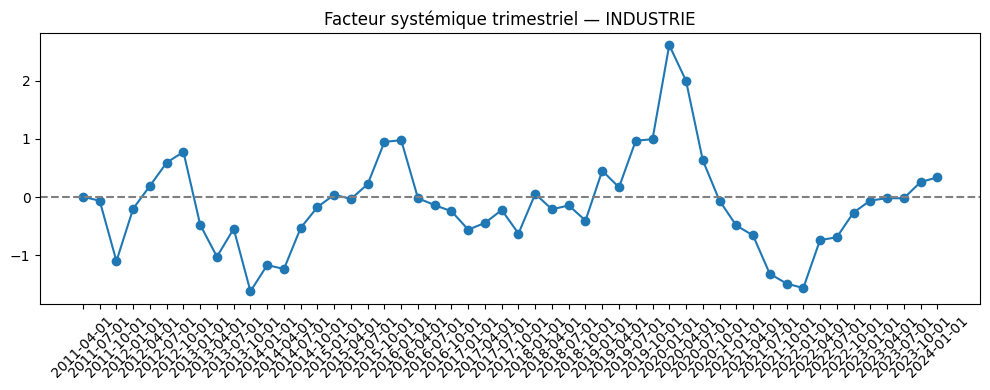

In [27]:
plot_Z_quarterly(Z_hat_q, "INDUSTRIE")

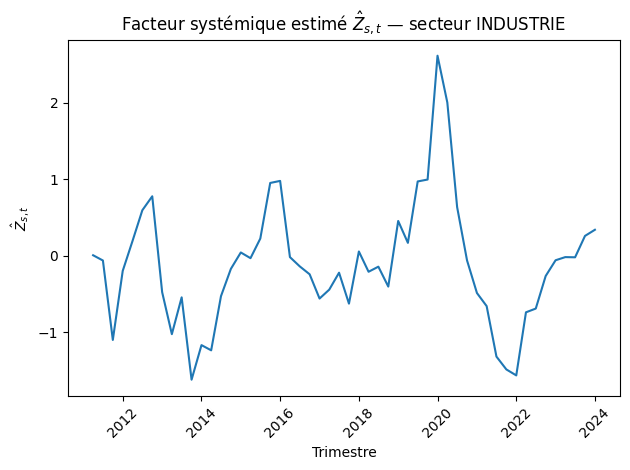

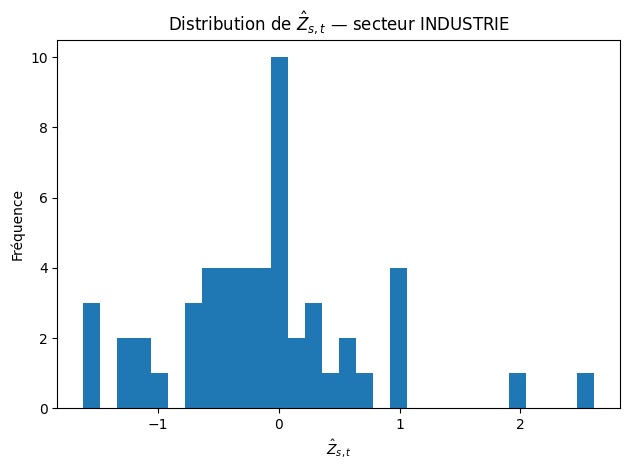

In [28]:
sector_show = "INDUSTRIE"  # change si besoin

Zs = Z_hat_q[Z_hat_q["sector"] == sector_show].copy()
Zs = Zs[Zs["success"]].copy()

# Série temporelle
plt.figure()
plt.plot(Zs["quarter"], Zs["z_hat"])
plt.title(f"Facteur systémique estimé $\\hat{{Z}}_{{s,t}}$ — secteur {sector_show}")
plt.xlabel("Trimestre")
plt.ylabel("$\\hat{Z}_{s,t}$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution
plt.figure()
plt.hist(Zs["z_hat"], bins=30)
plt.title(f"Distribution de $\\hat{{Z}}_{{s,t}}$ — secteur {sector_show}")
plt.xlabel("$\\hat{Z}_{s,t}$")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()


In [29]:
rating_initial_show = "BBB"

# Seuils (frontières) entre catégories (AAA|AA|...|C|D)
# On affiche les seuils cumulés : après AAA, après AA, ..., après C
bar_table = barriers.loc[rating_initial_show, RATING_ORDER[:-1]].to_frame(name="barrier_phi_inv_cumprob")
print(bar_table)


        barrier_phi_inv_cumprob
rating                         
AAA                   -4.059013
AA                    -4.059013
A                     -2.334599
BBB                    2.253991
BB                     3.435544
B                      3.722677
C                      4.059013


In [32]:
# 1) Z doit avoir une variance raisonnable (pas tout collé à -6 ou +6)
print("Quantiles z_hat:", Z_hat_q["z_hat"].quantile([0.01, 0.5, 0.99]))

# 2) secteurs avec trop peu de masse
light = Z_hat_q.groupby("sector")["n_total"].median().sort_values().head(5)
print("Secteurs 'légers' (médiane n_total):\n", light)


Quantiles z_hat: 0.01   -2.198384
0.50   -0.099229
0.99    2.434938
Name: z_hat, dtype: float64
Secteurs 'légers' (médiane n_total):
 sector
SERVICES PRO                        64.5
PRIMAIRES & ÉNERGIE                200.5
CONSTRUCTION & IMMOBILIER          214.5
INFO-COM                           273.5
PUBLIC & SERVICES NON-MARCHANDS    314.5
Name: n_total, dtype: float64


In [33]:
import pandas as pd

# PIT observées
pit_obs = (
    counts_creditmetrics_q
    .groupby(["sector", "quarter", "rating_prev", "rating"], as_index=False)["n"]
    .sum()
)

# total par rating_prev
totals = (
    pit_obs.groupby(["sector", "quarter", "rating_prev"], as_index=False)["n"]
    .sum()
    .rename(columns={"n": "n_total"})
)

pit_obs = pit_obs.merge(totals, on=["sector", "quarter", "rating_prev"])
pit_obs["pit_obs"] = pit_obs["n"] / pit_obs["n_total"]

In [35]:
import numpy as np
from scipy.stats import norm

import pandas as pd

# 1) Barriers : wide -> long
barriers_long = (
    barriers
    .reset_index()  # rating_prev redevient une colonne
    .melt(
        id_vars="rating_prev",
        var_name="rating",
        value_name="barrier"
    )
)

# 2) Merge OK
pit_mod = (
    pit_obs
    .merge(Z_hat_q, on=["sector", "quarter"], how="left")
    .merge(barriers_long, on=["rating_prev", "rating"], how="left")
)


# ordonner les ratings
rating_order = ["AAA","AA","A","BBB","BB","B","C","D"]
rating_rank = {r:i for i,r in enumerate(rating_order)}

pit_mod["rank"] = pit_mod["rating"].map(rating_rank)

# calcul PIT modélisée
def compute_pit(row):
    z = row["z_hat"]
    b = row["barrier"]
    return norm.cdf(b - z)

pit_mod["pit_mod_raw"] = pit_mod.apply(compute_pit, axis=1)

# différence de probabilités cumulées
pit_mod = pit_mod.sort_values(["sector","quarter","rating_prev","rank"])
pit_mod["pit_mod"] = (
    pit_mod.groupby(["sector","quarter","rating_prev"])["pit_mod_raw"]
           .diff()
           .fillna(pit_mod["pit_mod_raw"])
)

pit_mod["abs_error"] = (pit_mod["pit_obs"] - pit_mod["pit_mod"]).abs()
pit_mod[['sector', 'quarter', 'rating_prev', 'rating', 'pit_obs', 'pit_mod', 'abs_error']].head(10)

,sector,quarter,rating_prev,rating,pit_obs,pit_mod,abs_error
1,CONSTRUCTION & IMMOBILIER,2011-04-01,BB,BBB,1.0,0.999874,0.000126
0,CONSTRUCTION & IMMOBILIER,2011-04-01,BB,BB,0.0,0.000126,0.000126
2,CONSTRUCTION & IMMOBILIER,2011-07-01,BB,BB,1.0,0.990832,0.009168
3,CONSTRUCTION & IMMOBILIER,2011-07-01,BBB,BBB,1.0,0.990391,0.009609
4,CONSTRUCTION & IMMOBILIER,2011-10-01,B,B,1.0,0.994458,0.005542
5,CONSTRUCTION & IMMOBILIER,2011-10-01,BB,BB,1.0,0.990229,0.009771
6,CONSTRUCTION & IMMOBILIER,2011-10-01,BBB,BBB,1.0,0.989763,0.010237
7,CONSTRUCTION & IMMOBILIER,2012-01-01,B,B,1.0,0.994514,0.005486
8,CONSTRUCTION & IMMOBILIER,2012-01-01,BB,BB,1.0,0.990322,0.009678
9,CONSTRUCTION & IMMOBILIER,2012-01-01,BBB,BBB,1.0,0.989860,0.010140


# Normalisation du facteur systémique

Exemple secteurs: <StringArray>
[      'CONSTRUCTION & IMMOBILIER',                         'FINANCE',
                       'INDUSTRIE',                        'INFO-COM',
             'PRIMAIRES & ÉNERGIE', 'PUBLIC & SERVICES NON-MARCHANDS',
                        'SERVICES',                    'SERVICES PRO']
Length: 8, dtype: string


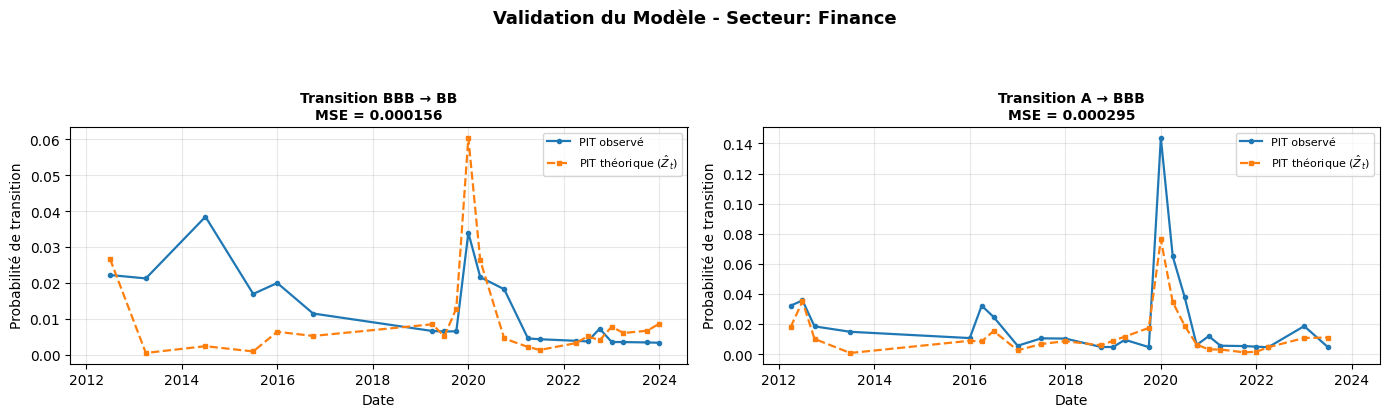

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

rating_order = ["AAA","AA","A","BBB","BB","B","C","D"]

# ----------------------------
# 1) PIT observé
# ----------------------------
def build_pit_observed(counts_creditmetrics, time_col="quarter"):
    df = counts_creditmetrics.copy()
    if "n" not in df.columns:
        for cand in ["count", "counts", "N", "nb", "value", "size"]:
            if cand in df.columns:
                df = df.rename(columns={cand: "n"})
                break
    if "n" not in df.columns:
        raise ValueError("Impossible de trouver la colonne de comptage (n).")

    denom = df.groupby(["sector", time_col, "rating_prev"])["n"].transform("sum")
    df["pit_obs"] = df["n"] / denom
    return df[["sector", time_col, "rating_prev", "rating", "pit_obs"]]


# ----------------------------
# 2) PIT théorique via Z_t + barrières + rho
# ----------------------------
def build_thresholds(barriers, rating_order=rating_order):
    """
    barriers : DataFrame index=rating_prev, columns=rating (cumul Phi^{-1})
    thresholds[r_prev] = [-inf, b_AAA, b_AA, ..., b_C, +inf]
    """
    barriers = barriers.reindex(index=rating_order, columns=rating_order)
    finite_cols = rating_order[:-1]  # AAA..C
    thresholds = {}
    for r_prev in rating_order:
        t = [-np.inf]
        for k in finite_cols:
            t.append(float(barriers.loc[r_prev, k]))
        t.append(np.inf)
        thresholds[r_prev] = np.array(t, dtype=float)
    return thresholds


def pit_probs_given_z(r_prev, z, thresholds, rho=0.20, rating_order=rating_order):
    """
    Retourne P(r_prev -> each rating) conditionnel à z,
    avec X|z ~ N(sqrt(rho)*z, 1-rho)
    """
    a = np.sqrt(rho)
    b = np.sqrt(1 - rho)

    t = thresholds[r_prev]  # taille K+1
    probs = []
    for j in range(len(rating_order)):
        lo, up = t[j], t[j+1]
        # standardisation conditionnelle
        u = (up - a*z) / b
        l = (lo - a*z) / b
        probs.append(norm.cdf(u) - norm.cdf(l))

    p = np.array(probs, dtype=float)
    p = np.clip(p, 0.0, 1.0)
    s = p.sum()
    if s > 0:
        p = p / s
    return p


def build_pit_theoretical(Z_hat, barriers, rho=0.20, time_col="quarter"):
    thresholds = build_thresholds(barriers, rating_order=rating_order)

    Z = Z_hat.copy()
    Z[time_col] = pd.to_datetime(Z[time_col]).dt.normalize()

    rows = []
    for (sector, t), z in Z.set_index(["sector", time_col])["z_hat"].items():
        for r_prev in rating_order:
            probs = pit_probs_given_z(r_prev, z, thresholds, rho=rho, rating_order=rating_order)
            for r, pr in zip(rating_order, probs):
                rows.append((sector, t, r_prev, r, pr))

    return pd.DataFrame(rows, columns=["sector", time_col, "rating_prev", "rating", "pit_theo"])


# ----------------------------
# 3) Graph "comme ton exemple" (2 transitions)
# ----------------------------
def plot_validation_two_transitions(pit_obs_df, pit_theo_df, sector, transitions,
                                    time_col="quarter", title_sector=None):

    df = pit_obs_df.merge(
        pit_theo_df, on=["sector", time_col, "rating_prev", "rating"], how="inner"
    )
    df = df[df["sector"] == sector].copy()
    df[time_col] = pd.to_datetime(df[time_col]).dt.normalize()

    fig, axes = plt.subplots(1, 2, figsize=(14, 4.3), sharex=True)
    fig.suptitle(
        title_sector if title_sector else f"Validation du Modèle - Secteur: {sector}",
        fontsize=13, fontweight="bold"
    )

    for ax, (r_prev, r) in zip(axes, transitions):
        sub = df[(df["rating_prev"] == r_prev) & (df["rating"] == r)].sort_values(time_col).copy()

        if sub.empty:
            ax.set_title(f"Transition {r_prev} → {r}\n(Aucune donnée)", fontsize=10, fontweight="bold")
            ax.grid(True, alpha=0.3)
            continue

        mse = np.mean((sub["pit_obs"] - sub["pit_theo"])**2)

        ax.plot(sub[time_col], sub["pit_obs"], marker="o", markersize=3,
                linewidth=1.6, label="PIT observé")
        ax.plot(sub[time_col], sub["pit_theo"], marker="s", markersize=3,
                linewidth=1.6, linestyle="--", label=r"PIT théorique ($\hat Z_t$)")

        ax.set_title(f"Transition {r_prev} → {r}\nMSE = {mse:.6f}", fontsize=10, fontweight="bold")
        ax.set_xlabel("Date")
        ax.set_ylabel("Probabilité de transition")
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc="upper right")

    plt.tight_layout(rect=[0, 0.02, 1, 0.90])
    plt.show()


# =========================================================
# UTILISATION
# =========================================================
# 1) PIT observées
pit_obs = build_pit_observed(counts_creditmetrics_q, time_col="quarter")

# 2) PIT théoriques (avec rho)
pit_theo = build_pit_theoretical(Z_hat_q, barriers, rho=0.20, time_col="quarter")

# 3) Choisir un secteur EXISTANT
print("Exemple secteurs:", counts_creditmetrics_q["sector"].unique()[:10])

# 4) Plot
plot_validation_two_transitions(
    pit_obs_df=pit_obs,
    pit_theo_df=pit_theo,
    sector="FINANCE",  # mets un libellé exact
    transitions=[("BBB","BB"), ("A","BBB")],
    time_col="quarter",
    title_sector="Validation du Modèle - Secteur: Finance"
)


In [37]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def ttc_probs_unconditional(r_prev, thresholds, rating_order=rating_order):
    """
    Probabilités TTC théoriques: P(r_prev -> each rating) non conditionnel à z.
    Ici X ~ N(0,1) inconditionnellement, donc P = Φ(up) - Φ(lo).
    """
    t = thresholds[r_prev]  # taille K+1
    probs = []
    for j in range(len(rating_order)):
        lo, up = t[j], t[j+1]
        probs.append(norm.cdf(up) - norm.cdf(lo))

    p = np.array(probs, dtype=float)
    p = np.clip(p, 0.0, 1.0)
    s = p.sum()
    if s > 0:
        p = p / s
    return p


def build_ttc_theoretical(Z_hat, barriers, time_col="quarter"):
    """
    Construit P_TTC théorique (non conditionnel à z).
    - On garde 'sector' pour matcher ta structure (même si TTC ne dépend pas du temps).
    - On retourne une table longue : (sector, rating_prev, rating, ttc_theo).
    """
    thresholds = build_thresholds(barriers, rating_order=rating_order)

    # secteurs présents (si tu veux une TTC globale, remplace par ['ALL'])
    sectors = (
        Z_hat["sector"].dropna().unique().tolist()
        if ("sector" in Z_hat.columns)
        else ["ALL"]
    )

    rows = []
    for sector in sectors:
        for r_prev in rating_order:
            probs = ttc_probs_unconditional(r_prev, thresholds, rating_order=rating_order)
            for r, pr in zip(rating_order, probs):
                rows.append((sector, r_prev, r, pr))

    return pd.DataFrame(rows, columns=["sector", "rating_prev", "rating", "ttc_theo"])


In [39]:
pttc_theo = build_ttc_theoretical(Z_hat_q, barriers, time_col="quarter")["ttc_theo"]
p_ttc_obs= P_ttc.copy()

In [42]:
P_ttc_obs_long = (
    p_ttc_obs
    .stack()
    .rename("p_ttc_obs")
    .reset_index()  # rating_prev, rating, p_ttc_obs
)


In [44]:
df = pit_obs.merge(
    P_ttc_obs_long,
    on=["rating_prev", "rating"],
    how="left"
)


In [46]:
P_ttc_obs=df["p_ttc_obs"]

In [40]:
p_ttc_obs

rating,AAA,AA,A,BBB,BB,B,C,D
rating_prev,,,,,,,,
AAA,0.981268,0.0,0.018420,0.000312,0.000000,0.000000,0.000000,0.000000
AA,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A,0.004321,0.0,0.979730,0.015571,0.000343,0.000034,0.000000,0.000000
BBB,0.000025,0.0,0.009758,0.978119,0.011803,0.000197,0.000074,0.000025
BB,0.000000,0.0,0.000174,0.009491,0.978775,0.011342,0.000152,0.000065
B,0.000000,0.0,0.000033,0.000228,0.009854,0.983251,0.006407,0.000228
C,0.000000,0.0,0.000000,0.000107,0.000534,0.015702,0.980987,0.002670
D,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [41]:
pttc_theo

0      0.981268
1      0.000000
2      0.018420
3      0.000312
4      0.000000
         ...   
507    0.000000
508    0.000000
509    0.000000
510    0.000000
511    1.000000
Name: ttc_theo, Length: 512, dtype: float64

In [75]:
import pandas as pd
import numpy as np

# Copie propre
Z_std = Z_hat_q.copy()

# Centrage-réduction par secteur
Z_std["z_hat"] = (
    Z_std
    .groupby("sector")["z_hat"]
    .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
)

Z_std.head()


,sector,quarter,z_hat,nll,success,n_obs_cells,n_total
0,CONSTRUCTION & IMMOBILIER,2011-04-01,-5.367888,0.711687,True,1,1
1,CONSTRUCTION & IMMOBILIER,2011-07-01,0.336412,0.102959,True,2,10
2,CONSTRUCTION & IMMOBILIER,2011-10-01,0.359294,0.180022,True,3,18
3,CONSTRUCTION & IMMOBILIER,2012-01-01,0.355846,0.220783,True,3,22
4,CONSTRUCTION & IMMOBILIER,2012-04-01,0.353953,0.241528,True,3,24


In [72]:
check_stats = (
    Z_std
    .groupby("sector")["z_std"]
    .agg(["mean", "std", "min", "max", "count"])
    .reset_index()
)

print(check_stats)


                            sector          mean       std       min  \
0        CONSTRUCTION & IMMOBILIER  4.376841e-17  1.009756 -5.367888   
1                          FINANCE -1.708035e-17  1.009756 -2.053147   
2                        INDUSTRIE  1.921540e-17  1.009756 -1.859139   
3                         INFO-COM  1.601283e-17  1.009756 -2.344751   
4              PRIMAIRES & ÉNERGIE  3.202566e-18  1.009756 -1.960455   
5  PUBLIC & SERVICES NON-MARCHANDS  8.540177e-18  1.009756 -1.994247   
6                         SERVICES -1.959217e-17  1.009950 -1.840612   
7                     SERVICES PRO  0.000000e+00  1.010153 -2.689525   

        max  count  
0  2.299244     52  
1  2.939765     52  
2  3.390457     52  
3  3.006378     52  
4  2.389868     52  
5  2.760122     52  
6  3.397992     51  
7  2.587388     50  


In [ ]:
# 1) PIT observées
pit_obs = build_pit_observed(counts_creditmetrics_q, time_col="quarter")

# 2) PIT théoriques (avec rho)
pit_theo = build_pit_theoretical(Z_std, barriers, rho=0.20, time_col="quarter")

# 3) Choisir un secteur EXISTANT
print("Exemple secteurs:", counts_creditmetrics_q["sector"].unique()[:10])

# 4) Plot
plot_validation_two_transitions(
    pit_obs_df=pit_obs,
    pit_theo_df=pit_theo,
    sector="FINANCE",  # mets un libellé exact
    transitions=[("BBB","BB"), ("A","BBB")],
    time_col="quarter",
    title_sector="Validation du Modèle - Secteur: Finance"
)

Exemple secteurs: <StringArray>
[      'CONSTRUCTION & IMMOBILIER',                         'FINANCE',
                       'INDUSTRIE',                        'INFO-COM',
             'PRIMAIRES & ÉNERGIE', 'PUBLIC & SERVICES NON-MARCHANDS',
                        'SERVICES',                    'SERVICES PRO']
Length: 8, dtype: string


AttributeError: 'Series' object has no attribute 'merge'

In [58]:
def plot_pred_obs(pit_mod):
            """
            Trace la comparaison entre PD PIT observée et PD PIT prédite.
            """
            pit_obs = pd.DataFrame(build_pit_observed(counts_creditmetrics_q, time_col="quarter"))
            pit_theo = pd.DataFrame(build_pit_theoretical(Z_hat_q, barriers, rho=0.20, time_col="quarter"))


            plt.figure(figsize=(10, 5))
            plt.plot(pit_obs.index, pit_obs.values, label="Observed PD PIT", color="blue")
            plt.plot(pit_theo.index, pit_theo.values, label="Predicted PD PIT (Merton)", color="red", linestyle="--")
            plt.title("Observed vs Predicted PIT Default Probabilities (Merton Homogène)")
            plt.xlabel("Date")
            plt.ylabel("Default Probability")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()


TypeError: unhashable type: 'numpy.ndarray'

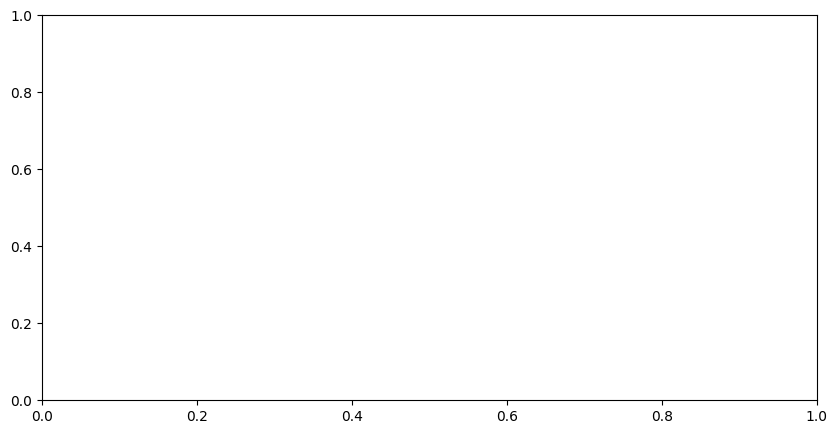

In [59]:
plot_pred_obs(pit_mod)

In [73]:
tol = 1e-6

check_stats["mean_ok"] = check_stats["mean"].abs() < tol
check_stats["std_ok"] = (check_stats["std"] - 1).abs() < tol

check_stats[["sector", "mean_ok", "std_ok"]]


,sector,mean_ok,std_ok
0,CONSTRUCTION & IMMOBILIER,True,False
1,FINANCE,True,False
2,INDUSTRIE,True,False
3,INFO-COM,True,False
4,PRIMAIRES & ÉNERGIE,True,False
5,PUBLIC & SERVICES NON-MARCHANDS,True,False
6,SERVICES,True,False
7,SERVICES PRO,True,False


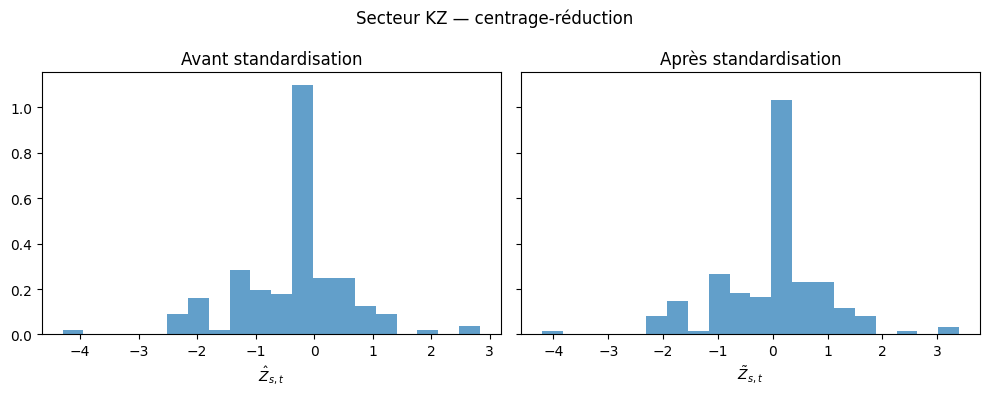

In [26]:
import matplotlib.pyplot as plt

sector_show = "KZ"

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].hist(
    Z_hat[Z_hat["sector"] == sector_show]["z_hat"],
    bins=20, density=True, alpha=0.7
)
axes[0].set_title("Avant standardisation")
axes[0].set_xlabel(r"$\hat Z_{s,t}$")

axes[1].hist(
    Z_std[Z_std["sector"] == sector_show]["z_std"],
    bins=20, density=True, alpha=0.7
)
axes[1].set_title("Après standardisation")
axes[1].set_xlabel(r"$\tilde Z_{s,t}$")

plt.suptitle(f"Secteur {sector_show} — centrage-réduction")
plt.tight_layout()
plt.show()


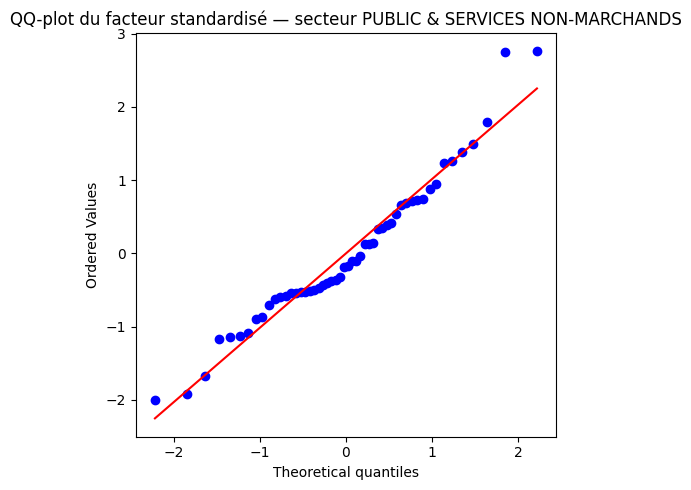

In [ ]:
from scipy.stats import probplot

plt.figure(figsize=(5,5))
probplot(
    Z_std[Z_std["sector"] == "PUBLIC & SERVICES NON-MARCHANDS"]["z_hat"].dropna(),
    dist="norm",
    plot=plt
)
plt.title(f"QQ-plot du facteur standardisé — secteur PUBLIC & SERVICES NON-MARCHANDS")
plt.tight_layout()
plt.show()


In [83]:
import os
import json
import pandas as pd

EXPORT_DIR = "exports_step1_creditmetrics_csv"
os.makedirs(EXPORT_DIR, exist_ok=True)

def save_csv(df: pd.DataFrame, name: str):
    path = os.path.join(EXPORT_DIR, f"{name}.csv")
    df.to_csv(path, index=False)
    print(f"✓ Saved {name}: {df.shape} -> {path}")


# =====================================================
# Objets attendus en mémoire :
# panel
# transitions
# counts_creditmetrics
# P_ttc
# barriers
# Z_hat
# =====================================================

# 1) Panel mensuel
save_csv(panel_q, "panel_monthly_ratings")

# 2) Transitions
save_csv(transitions_q, "transitions_monthly")

# 3) Comptages CreditMetrics (avec stays)
save_csv(counts_creditmetrics_q, "counts_creditmetrics_full")

# 4) Facteur systémique estimé
save_csv(Z_hat_q, "Z_hat_sector_month")

# 5) Facteur systémique standardisé
Z_std = Z_hat_q.copy()
Z_std["z_hat"] = (
    Z_std.groupby("sector")["z_hat"]
         .transform(lambda x: (x - x.mean()) / x.std())
)
save_csv(Z_std, "Z_hat_standardized_sector_q")

# 6) TTC (format long)
P_ttc_long = (
    P_ttc.reset_index()
         .melt(id_vars="rating_prev",
               var_name="rating",
               value_name="p_ttc")
)
save_csv(P_ttc_long, "P_ttc_global_long")

# 7) Barrières (format long)
barriers_long = (
    barriers.reset_index()
            .melt(id_vars="rating_prev",
                  var_name="rating",
                  value_name="barrier_phi_inv_cumprob")
)
save_csv(barriers_long, "barriers_global_long")


# 8) Métadonnées (choix méthodologiques)
meta = {
    "rho": 0.20,
    "rating_order": ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"],
    "agency_used": "Egan-Jones Ratings Company",
    "frequency": "monthly",
    "notes": "counts_creditmetrics_full inclut les stays (r->r). Barrières dérivées de la TTC globale."
}

with open(os.path.join(EXPORT_DIR, "metadata_step1.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("\n✓ Tous les fichiers CSV + metadata exportés")


✓ Saved panel_monthly_ratings: (87597, 4) -> exports_step1_creditmetrics_csv\panel_monthly_ratings.csv
✓ Saved transitions_monthly: (83074, 6) -> exports_step1_creditmetrics_csv\transitions_monthly.csv
✓ Saved counts_creditmetrics_full: (3818, 5) -> exports_step1_creditmetrics_csv\counts_creditmetrics_full.csv
✓ Saved Z_hat_sector_month: (413, 7) -> exports_step1_creditmetrics_csv\Z_hat_sector_month.csv
✓ Saved Z_hat_standardized_sector_q: (413, 7) -> exports_step1_creditmetrics_csv\Z_hat_standardized_sector_q.csv
✓ Saved P_ttc_global_long: (64, 3) -> exports_step1_creditmetrics_csv\P_ttc_global_long.csv
✓ Saved barriers_global_long: (64, 3) -> exports_step1_creditmetrics_csv\barriers_global_long.csv

✓ Tous les fichiers CSV + metadata exportés


In [22]:
Z_hat

,sector,month,z_hat,nll,success,n_obs_cells,n_total
0,AZ,2011-06-01,-0.457159,0.003500,True,1,2
1,AZ,2011-07-01,-0.457159,0.003500,True,1,2
2,AZ,2011-08-01,-0.457159,0.003500,True,1,2
3,AZ,2011-09-01,-0.457159,0.003500,True,1,2
4,AZ,2011-10-01,-0.457159,0.003500,True,1,2
...,...,...,...,...,...,...,...
2790,RU,2023-11-01,0.289406,8.533978,True,8,1115
2791,RU,2023-12-01,0.529571,15.363542,True,9,1148
2792,RU,2024-01-01,0.513405,14.919499,True,8,1172
2793,RU,2024-02-01,0.943029,33.273048,True,10,1184


## REGROUPEMENT CORRELATION DES FACTEURS SYSTEMIQUE

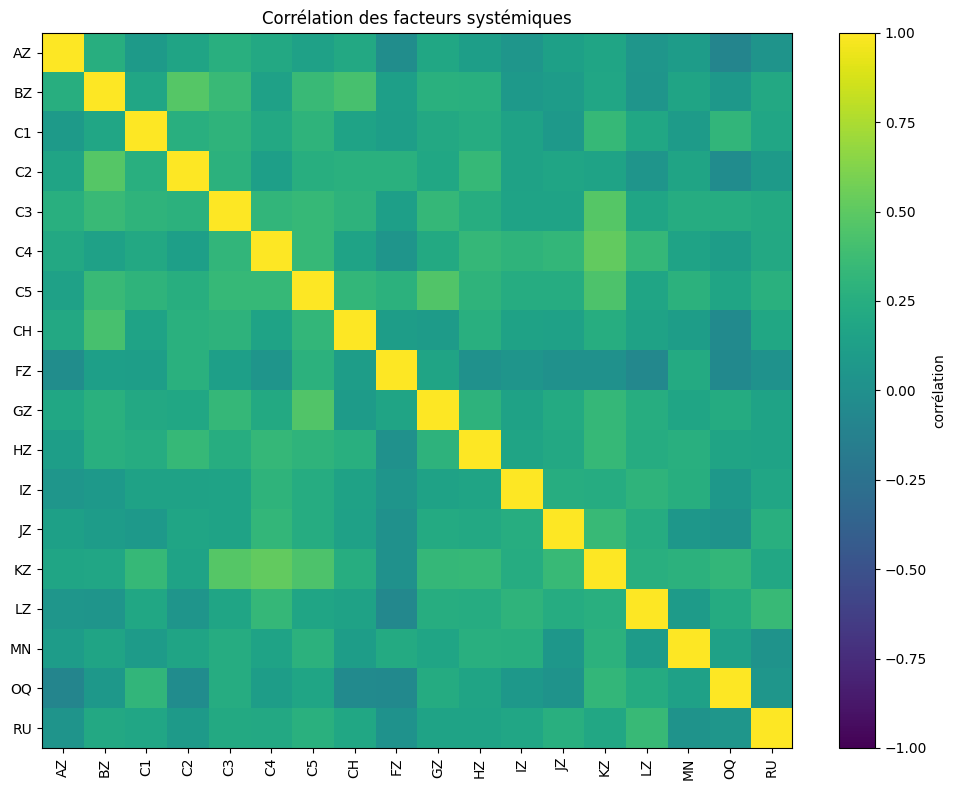

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def corr_matrix_Z(df_Z, date_col="date", sector_col="sector", z_col="Z",
                  method="pearson", min_periods=24):
    """
    Retourne:
      - Z_wide : matrice (dates x secteurs) des facteurs
      - corr   : matrice de corrélation (secteurs x secteurs)
    min_periods: nb min de dates communes pour calculer une corrélation.
    """
    # Pivot: dates x secteurs
    Z_wide = (df_Z
              .pivot_table(index=date_col, columns=sector_col, values=z_col, aggfunc="mean")
              .sort_index())

    # Corrélation avec gestion des NA
    corr = Z_wide.corr(method=method, min_periods=min_periods)

    return Z_wide, corr


def plot_corr_heatmap(corr, title="Corrélation des facteurs systémiques", figsize=(10, 8),
                      vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr.values, vmin=vmin, vmax=vmax, aspect="auto")
    ax.set_title(title)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticklabels(corr.index)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("corrélation")
    plt.tight_layout()
    plt.show()


# --- Usage ---
Z_wide, corr = corr_matrix_Z(Z_hat, date_col="month", sector_col="sector", z_col="z_hat")
plot_corr_heatmap(corr)


In [26]:
corr

sector,AZ,BZ,C1,C2,C3,C4,C5,CH,FZ,GZ,HZ,IZ,JZ,KZ,LZ,MN,OQ,RU
sector,,,,,,,,,,,,,,,,,,
AZ,1.000000,0.252614,0.090182,0.170608,0.260405,0.203611,0.144567,0.203846,-0.019796,0.190798,0.124657,0.050530,0.135045,0.177210,0.054324,0.104380,-0.092334,0.031482
BZ,0.252614,1.000000,0.186683,0.469084,0.355462,0.143754,0.355832,0.417515,0.127466,0.265771,0.258489,0.071664,0.103522,0.181028,0.043363,0.167077,0.062798,0.210323
C1,0.090182,0.186683,1.000000,0.265463,0.304642,0.205120,0.302402,0.162237,0.118270,0.210333,0.241829,0.148806,0.084592,0.340768,0.192083,0.097027,0.313619,0.184757
C2,0.170608,0.469084,0.265463,1.000000,0.282090,0.130337,0.255089,0.268428,0.271300,0.189385,0.338795,0.151648,0.172318,0.156821,0.044130,0.165427,-0.029515,0.092984
C3,0.260405,0.355462,0.304642,0.282090,1.000000,0.315856,0.336201,0.292733,0.129015,0.332043,0.243111,0.158848,0.160082,0.475538,0.173549,0.236288,0.234688,0.213593
C4,0.203611,0.143754,0.205120,0.130337,0.315856,1.000000,0.337686,0.164062,0.039102,0.215240,0.332910,0.298190,0.321350,0.520430,0.329365,0.163397,0.113949,0.208847
C5,0.144567,0.355832,0.302402,0.255089,0.336201,0.337686,1.000000,0.327174,0.283053,0.458092,0.303786,0.240810,0.241541,0.441493,0.176296,0.286460,0.177444,0.270200
CH,0.203846,0.417515,0.162237,0.268428,0.292733,0.164062,0.327174,1.000000,0.109921,0.093806,0.260676,0.150128,0.145849,0.243066,0.154102,0.116784,-0.040164,0.190384
FZ,-0.019796,0.127466,0.118270,0.271300,0.129015,0.039102,0.283053,0.109921,1.000000,0.168644,0.008517,0.044328,0.011435,0.011969,-0.066033,0.225484,-0.054606,0.017639


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

def cluster_sectors_from_corr(corr, n_groups=8, method="average", plot=True, figsize=(12, 5)):
    """
    corr: DataFrame (secteurs x secteurs)
    n_groups: nb de groupes souhaités
    method: 'average', 'complete', 'ward' (ward nécessite une distance euclidienne)
    Retour:
      - groups: Series secteur -> id_groupe
    """
    # distance = 1 - corr ; on remplace NA par 0 de corr => distance 1
    corr_filled = corr.fillna(0.0)
    dist = 1.0 - corr_filled

    # squareform attend une matrice de distance symétrique avec diagonale 0
    np.fill_diagonal(dist.values, 0.0)
    dist_condensed = squareform(dist.values, checks=False)

    Z_link = linkage(dist_condensed, method=method)

    if plot:
        plt.figure(figsize=figsize)
        dendrogram(Z_link, labels=corr.index.tolist(), leaf_rotation=90)
        plt.title("Dendrogramme — clustering secteurs (distance = 1 - corr)")
        plt.tight_layout()
        plt.show()

    cluster_ids = fcluster(Z_link, t=n_groups, criterion="maxclust")
    groups = pd.Series(cluster_ids, index=corr.index, name="cluster_id").sort_values()

    return groups


# --- Usage ---
groups = cluster_sectors_from_corr(corr, n_groups=7, method="average", plot=True)
print(groups)


## REGROUPEMENT ECONOMIQUE

In [ ]:
import pandas as pd
import numpy as np

# 1) Mapping économique (à adapter si C1..C5 sont connus chez toi)
ECON_GROUP_MAP = {
    # Primaires / énergie
    "AZ": "Primaires & énergie",
    "BZ": "Primaires & énergie",  # si présent

    # Industrie / construction / immobilier
    "CZ": "Industrie",
    "FZ": "Construction & immobilier",
    "LZ": "Construction & immobilier",

    # Transport / info
    "HZ": "Transport & info-com",
    "JZ": "Transport & info-com",

    # Services marchands
    "GZ": "Services marchands",
    "IZ": "Services marchands",

    # Finance
    "KZ": "Finance",

    # Non-marchands / public
    "OQ": "Public & services non-marchands",
    "RU": "Public & services non-marchands",

    # Services pro (souvent très cycliques mais “services”)
    "MN": "Services pro",

    # Cas C1..C5 (à défaut)
    "C1": "Industrie",
    "C2": "Industrie",
    "C3": "Industrie",
    "C4": "Industrie",
    "C5": "Industrie",
    "G7": "Services marchands",  # tu avais G7 dans le dendrogramme
}

 , 'OQ', 'C5', 'KZ', 'HZ', 'GZ', 'MN', 'C1', 'FZ', 'C3',
       'LZ', 'CH', 'C4', 'BZ', 'IZ', 'AZ', 'C2'

def add_econ_group(df_Z, sector_col="sector"):
    df = df_Z.copy()
    df["econ_group"] = df[sector_col].map(ECON_GROUP_MAP).fillna("Autres")
    return df

# Usage
df_Z2 = add_econ_group(Z_hat, sector_col="sector")
df_Z2["econ_group"].value_counts()


econ_group
Services marchands                 619
Industrie                          315
Public & services non-marchands    314
Primaires & énergie                310
Services pro                       310
Transport & info-com               310
Construction & immobilier          305
Finance                            158
Autres                             154
Name: count, dtype: int64

In [26]:
def aggregate_Z_by_econ_group(df_Z2, date_col="date", group_col="econ_group", z_col="Z"):
    out = (df_Z2
           .groupby([date_col, group_col], as_index=False)[z_col]
           .mean()
           .rename(columns={z_col: "Z_group"}))
    return out

# Usage
df_group = aggregate_Z_by_econ_group(df_Z2, date_col="month", group_col="econ_group", z_col="z_hat")


In [27]:
df_group

,month,econ_group,Z_group
0,2011-02-01,Construction & immobilier,-0.058740
1,2011-02-01,Finance,-4.300409
2,2011-02-01,Industrie,-0.082408
3,2011-02-01,Public & services non-marchands,-0.457159
4,2011-02-01,Services pro,-0.058740
...,...,...,...
1407,2024-03-01,Primaires & énergie,-0.090776
1408,2024-03-01,Public & services non-marchands,0.364581
1409,2024-03-01,Services marchands,0.231188
1410,2024-03-01,Services pro,0.650863


In [28]:
def corr_intra_inter(df_Z2, date_col="month", sector_col="sector", z_col="z_hat", group_col="econ_group"):
    # matrice secteurs
    Z_wide = (df_Z2.pivot_table(index=date_col, columns=sector_col, values=z_col, aggfunc="mean")
                    .sort_index())
    corr = Z_wide.corr(min_periods=24)

    # associer chaque secteur à son groupe
    sector_to_group = (df_Z2[[sector_col, group_col]]
                       .drop_duplicates()
                       .set_index(sector_col)[group_col]
                       .to_dict())

    sectors = corr.index.tolist()
    intra = []
    inter = []

    for i in range(len(sectors)):
        for j in range(i+1, len(sectors)):
            s1, s2 = sectors[i], sectors[j]
            c = corr.loc[s1, s2]
            if pd.isna(c):
                continue
            if sector_to_group.get(s1, "Autres") == sector_to_group.get(s2, "Autres"):
                intra.append(c)
            else:
                inter.append(c)

    return {
        "corr_matrix": corr,
        "intra_mean": float(np.mean(intra)) if intra else np.nan,
        "inter_mean": float(np.mean(inter)) if inter else np.nan,
        "intra_median": float(np.median(intra)) if intra else np.nan,
        "inter_median": float(np.median(inter)) if inter else np.nan,
        "n_intra_pairs": len(intra),
        "n_inter_pairs": len(inter),
    }

# Usage
diag = corr_intra_inter(df_Z2)
diag["intra_mean"], diag["inter_mean"], diag["n_intra_pairs"]


(0.20602468227428639, 0.19552443285047547, 12)

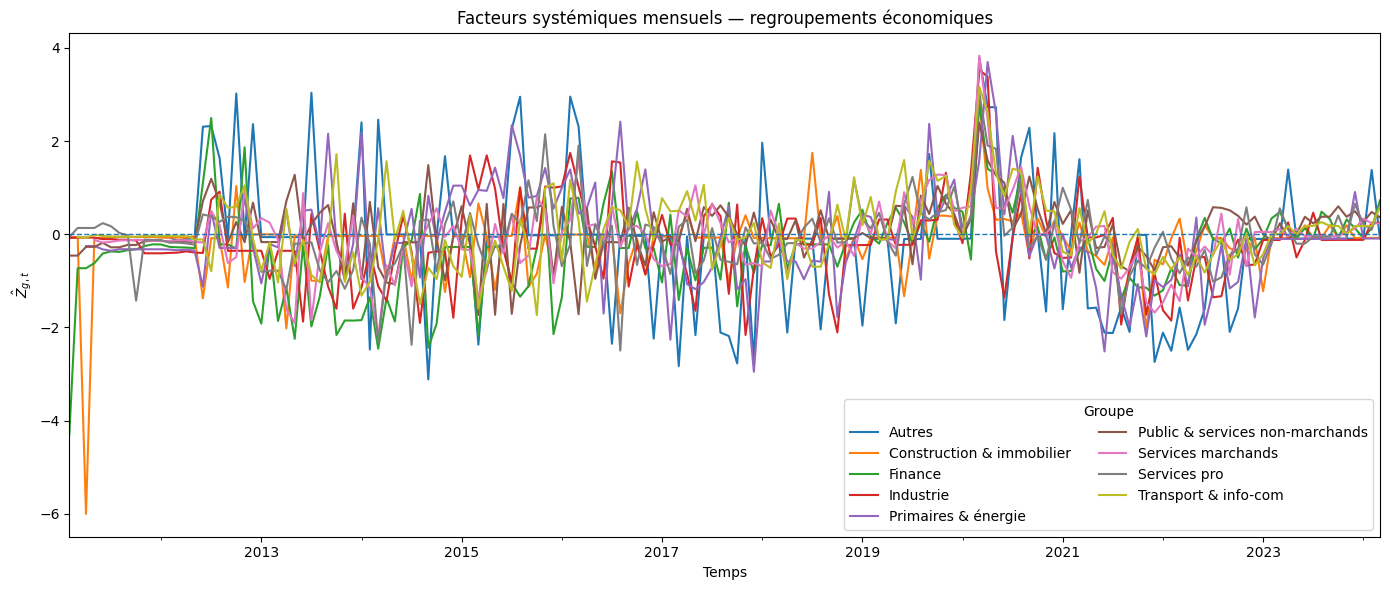

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_group_factors_from_sectors(df_Z2, date_col="month", group_col="econ_group", z_col="z_hat",
                                    title="Facteurs systémiques mensuels — regroupements économiques"):
    df = df_Z2.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # agrégation mensuelle par groupe (moyenne des secteurs dans le groupe)
    df_group = (df.groupby([date_col, group_col], as_index=False)[z_col]
                  .mean()
                  .rename(columns={z_col: "Z_group"}))

    wide = (df_group.pivot_table(index=date_col, columns=group_col, values="Z_group", aggfunc="mean")
                    .sort_index())

    ax = wide.plot(figsize=(14, 6), linewidth=1.5)
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Temps")
    ax.set_ylabel(r"$\hat{Z}_{g,t}$")
    ax.legend(title="Groupe", ncol=2, frameon=True)
    plt.tight_layout()
    plt.show()

# Exemple:
plot_group_factors_from_sectors(df_Z2)


In [30]:
import pandas as pd

def Z_groups_to_quarterly(df_group,
                          date_col="date",
                          group_col="econ_group",
                          z_col="Z_group"):
    df = df_group.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # créer la date trimestrielle
    df["date_q"] = df[date_col].dt.to_period("Q").dt.to_timestamp()

    # moyenne intra-trimestrielle
    df_q = (
        df.groupby(["date_q", group_col], as_index=False)[z_col]
          .mean()
          .sort_values([group_col, "date_q"])
    )

    return df_q


# ===== Usage =====
df_Z_group_q = Z_groups_to_quarterly(df_group, date_col="month", group_col="econ_group", z_col="Z_group")
df_Z_group_q


,date_q,econ_group,Z_group
6,2011-04-01,Autres,-0.058740
15,2011-07-01,Autres,-0.058740
24,2011-10-01,Autres,-0.058740
33,2012-01-01,Autres,-0.086835
42,2012-04-01,Autres,0.708281
...,...,...,...
437,2023-01-01,Transport & info-com,-0.139967
446,2023-04-01,Transport & info-com,0.120377
455,2023-07-01,Transport & info-com,0.206857
464,2023-10-01,Transport & info-com,0.120646


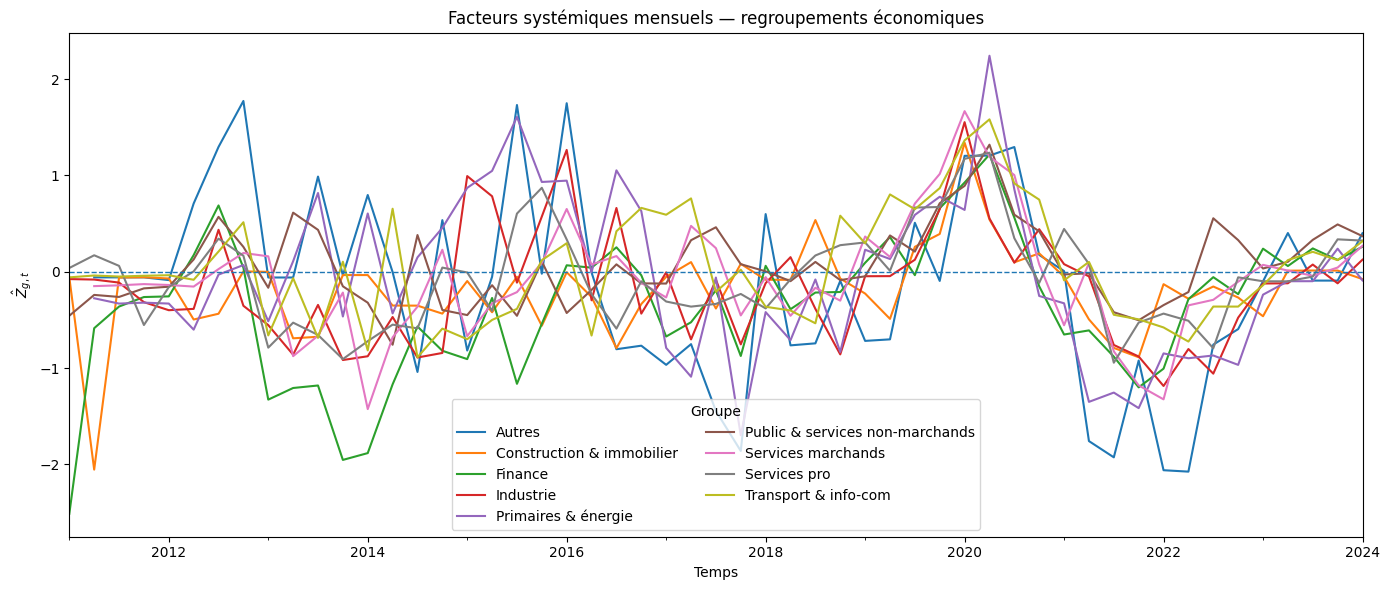

In [31]:
plot_group_factors_from_sectors(df_Z_group_q, date_col="date_q", group_col="econ_group", z_col="Z_group",
                                title="Facteurs systémiques mensuels — regroupements économiques")

In [32]:
df_Z_group_q.to_csv("exports_step1_creditmetrics_csv/Z_hat_econ_group_quarterly.csv", index=False)

# Images rapport

In [33]:
desc_table = pd.DataFrame({
    "Indicateur": [
        "Nombre d'entreprises",
        "Nombre d'observations de rating",
        "Nombre de secteurs",
        "Période couverte",
        "Agence de notation"
    ],
    "Valeur": [
        panel["obligor_id"].nunique(),
        len(panel),
        panel["sector"].nunique(),
        f"{panel['month'].min().date()} – {panel['month'].max().date()}",
        "Egan-Jones Ratings Company"
    ]
})

desc_table


,Indicateur,Valeur
0,Nombre d'entreprises,4552
1,Nombre d'observations de rating,305714
2,Nombre de secteurs,18
3,Période couverte,2011-01-01 – 2024-03-01
4,Agence de notation,Egan-Jones Ratings Company


In [34]:
agency_dist = (
    df_ej["rating_agency_name"]
    .value_counts()
    .rename_axis("Agence")
    .reset_index(name="Nombre d'observations")
)

agency_dist["Part (%)"] = 100 * agency_dist["Nombre d'observations"] / agency_dist["Nombre d'observations"].sum()
agency_dist


,Agence,Nombre d'observations,Part (%)
0,Egan-Jones Ratings Company,55414,100.0


In [35]:
transition_rate = transitions["changed"].mean()

pd.DataFrame({
    "Indicateur": ["Taux moyen de changement mensuel"],
    "Valeur": [f"{100 * transition_rate:.2f} %"]
})


,Indicateur,Valeur
0,Taux moyen de changement mensuel,1.12 %


In [36]:
P_ttc.loc[
    ["AAA", "AA", "A", "BBB"],
    ["AAA", "AA", "A", "BBB", "BB"]
]


rating,AAA,AA,A,BBB,BB
rating_prev,,,,,
AAA,0.994047,0.0,0.005859,0.000094,0.000000
AA,0.000000,0.0,0.000000,0.000000,0.000000
A,0.001332,0.0,0.993939,0.004628,0.000090
BBB,0.000007,0.0,0.002754,0.993785,0.003373


In [37]:
rating_init = "BBB"

barrier_table = (
    barriers.loc[rating_init, ["AAA","AA","A","BBB","BB","B","C"]]
    .to_frame(name="Seuil $\\Phi^{-1}(P)$")
)

barrier_table


,Seuil $\Phi^{-1}(P)$
rating,
AAA,-4.350229
AA,-4.350229
A,-2.774927
BBB,2.701220
BB,3.770081
B,4.035880
C,4.350229


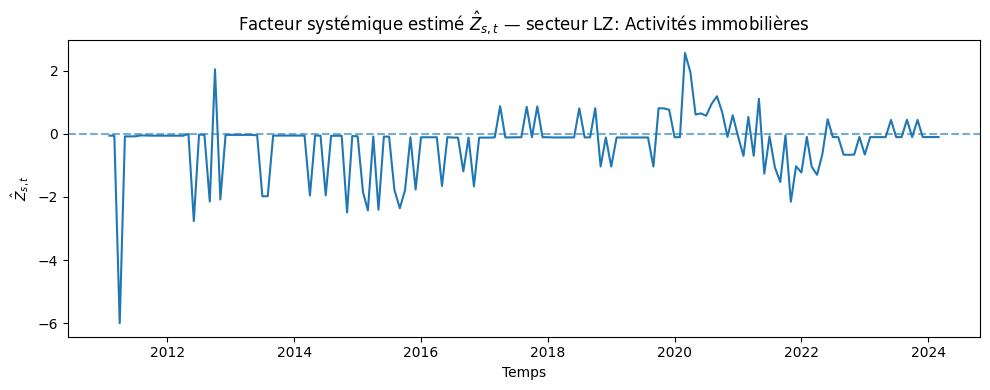

In [38]:
sector_show = "LZ"
Zs = Z_hat[Z_hat["sector"] == sector_show]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(Zs["month"], Zs["z_hat"])
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title(f"Facteur systémique estimé $\\hat{{Z}}_{{s,t}}$ — secteur {sector_show}: Activités immobilières")
plt.xlabel("Temps")
plt.ylabel("$\\hat{Z}_{s,t}$")
plt.tight_layout()
plt.show()


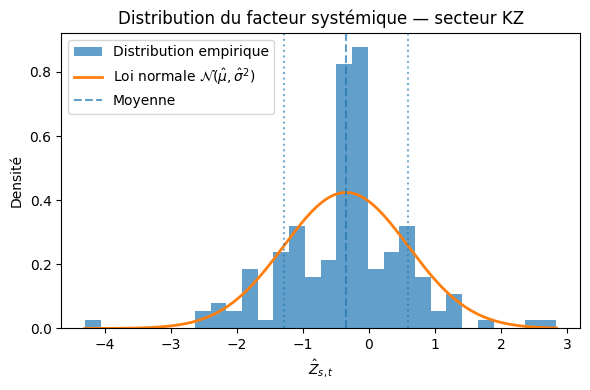

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Secteur à illustrer
sector_show = "KZ"   # adapte si besoin

# Données du facteur
Zs = Z_hat[Z_hat["sector"] == sector_show].copy()

# Paramètres empiriques
mu = Zs["z_hat"].mean()
sigma = Zs["z_hat"].std()

# Grille pour la densité normale
x = np.linspace(Zs["z_hat"].min(), Zs["z_hat"].max(), 300)

# Plot
plt.figure(figsize=(6,4))

# Histogramme normalisé
plt.hist(
    Zs["z_hat"],
    bins=30,
    density=True,
    alpha=0.7,
    label="Distribution empirique"
)

# Loi normale ajustée
plt.plot(
    x,
    norm.pdf(x, mu, sigma),
    linewidth=2,
    label=r"Loi normale $\mathcal{N}(\hat\mu,\hat\sigma^2)$"
)

plt.title(f"Distribution du facteur systémique — secteur {sector_show}")
plt.xlabel(r"$\hat{Z}_{s,t}$")
plt.ylabel("Densité")
plt.axvline(mu, linestyle="--", alpha=0.7, label="Moyenne")
plt.axvline(mu - sigma, linestyle=":", alpha=0.6)
plt.axvline(mu + sigma, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
Z_hat.groupby("sector")["z_hat"].agg(
    mean="mean",
    std="std",
    q01=lambda x: x.quantile(0.01),
    q99=lambda x: x.quantile(0.99),
    n_obs="count"
).round(3)


,mean,std,q01,q99,n_obs
sector,,,,,
AZ,-0.141,1.142,-3.454,3.050,154
BZ,0.038,1.421,-2.811,3.417,156
C1,-0.068,0.941,-2.523,2.378,158
C2,-0.249,1.294,-3.400,3.153,157
C3,-0.155,1.057,-2.395,1.866,154
C4,-0.110,1.278,-2.972,2.994,155
C5,-0.072,0.968,-2.188,2.152,158
CH,-0.137,1.373,-2.799,3.030,154
FZ,-0.031,0.924,-3.088,3.493,147
